In [12]:
library("Matrix")
library(Seurat)
library(DT)
library(dplyr)
library(here)
library(ggplot2)
library(mclust)
library(cowplot)
library(tidyverse)
library(reshape)
library(SingleR)
library(annotate)
library("org.Mm.eg.db")
library(biomaRt)
library(scCustomize)
library(future)
library(ggnewscale)
library(furrr)
library(readxl)
library(STACAS)
library(patchwork)
library(ggpubr)

rank_score_func <- function(df){

df <- df %>% mutate(score = -1*log(p_val_adj+(10^-310))*avg_logFC*(pct.1/(pct.2+10^-300)))

return(df)
}

convertHumanGeneList <- function(x){

require("biomaRt")
human = useMart("ensembl", dataset = "hsapiens_gene_ensembl")
mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl")

genesV2 = getLDS(attributes = c("hgnc_symbol"), filters = "hgnc_symbol", values = x , mart = human, attributesL = c("mgi_symbol"), martL = mouse, uniqueRows=T)

humanx <- unique(genesV2[, 2])

# Print the first 6 genes found to the screen
print(head(humanx))
return(humanx)
}

library("remotes")
library("fs")

ggtheme <- function() {
  theme(
    axis.text = element_text(size = 10),
    axis.title = element_text(size = 10),
      plot.title = element_text(size = 10),
    text = element_text(size = 10, colour = "black"),
    legend.text = element_text(size = 10),
    legend.key.size =  unit(10, units = "points")
    
  )
}

mid.se <- celldex::MonacoImmuneData();

snapshotDate(): 2020-10-27

see ?celldex and browseVignettes('celldex') for documentation

loading from cache

see ?celldex and browseVignettes('celldex') for documentation

loading from cache



### Read datasets

In [2]:
plan("multisession")

In [3]:
cd4_full_filt  <- readRDS("data/processed/cd4_full_filt.rds")
cd4_subcluster  <- readRDS("data/processed/cd4_subcluster.rds")
treg_subcluster  <- readRDS("data/processed/treg_subcluster.rds")
teff_subcluster  <- readRDS("data/processed/cd4_teff_subcluster.rds")


# Full dataset

## Cluster composition

In [6]:
cd4_full_filt@misc$colors_annotations_l1  <- c("#fe8f37ff","#901901ff")

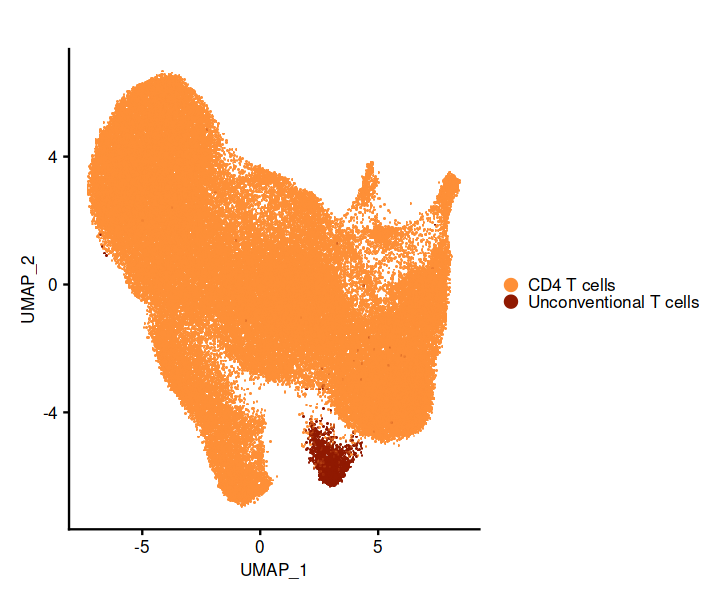

In [9]:
options(repr.plot.width = 6, repr.plot.height = 5)

dimplot1  <- DimPlot(cd4_full_filt, label = F, raster = T, group.by = "annotations_l1",
       cols = cd4_full_filt@misc$colors_annotations_l1) + ggtheme() + ggtitle("")
dimplot1

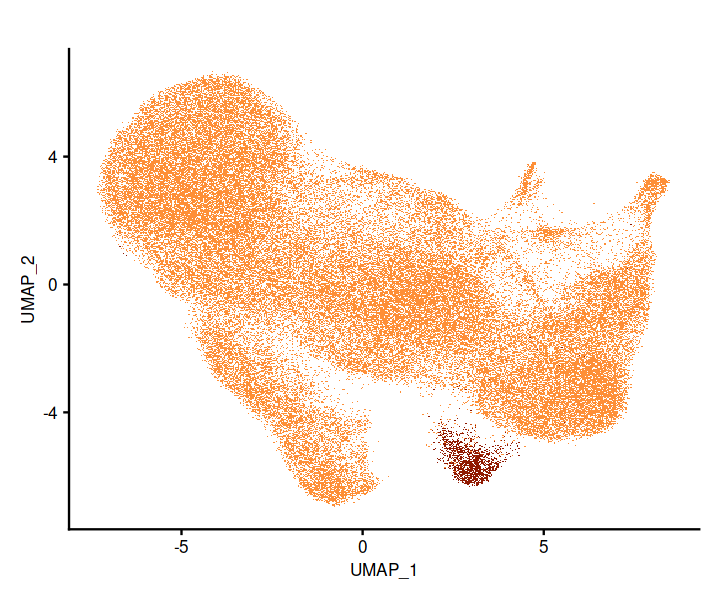

In [8]:
dimplot1 + NoLegend()
ggsave("dimplot_cd4_full_filt.png", width = 12, height = 12, units = "cm")
ggsave("dimplot_cd4_full_filt.svg", width = 12, height = 12, units = "cm")

In [10]:
options(repr.plot.width = 15, repr.plot.height = 5)

seurat_meta_data <- cd4_full_filt@meta.data

# Create grouped dataframe, calculate the frequencies of clusters
df4 <- seurat_meta_data %>% 
  group_by(Sample_ID, annotations_l1) %>% 
  summarise(n = n()) %>% 
  unique() %>% 
  mutate(freq = n / sum(n))  %>% 
dplyr::select(-n)  %>% 
ungroup   %>% 
pivot_wider(names_from = "annotations_l1", values_from = "freq", values_fill = 0)   %>% 
pivot_longer(!Sample_ID, values_to = "freq", names_to = "annotations_l1")
# Control - all sums should be one
# df4 %>% group_by(Sample_ID) %>% summarise(sum = sum(freq))

# As we've lost non-grouping variables, let's join them back
md_to_join <- seurat_meta_data %>% 
  dplyr::select(Sample_ID, Condition, Disease, Sex, Age, Age_group, Patient_ID, Time, Experiment_ID) %>% 
  unique()

df4  <- left_join(df4, md_to_join)

# The final plot

p0  <- df4 %>% 
  ggplot(aes(x = Condition, y = freq)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.7, width = 0.9, aes(fill = Condition)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, shape = 21, stackdir='center', aes(fill = Condition), color = "black") + 
  facet_wrap(~annotations_l1, scales = "free", ncol = 6) +
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
 ylim(0,NA) +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text.x = element_text(angle = 90))

`summarise()` has grouped output by 'Sample_ID'. You can override using the
`.groups` argument.
Joining with `by = join_by(Sample_ID)`
Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


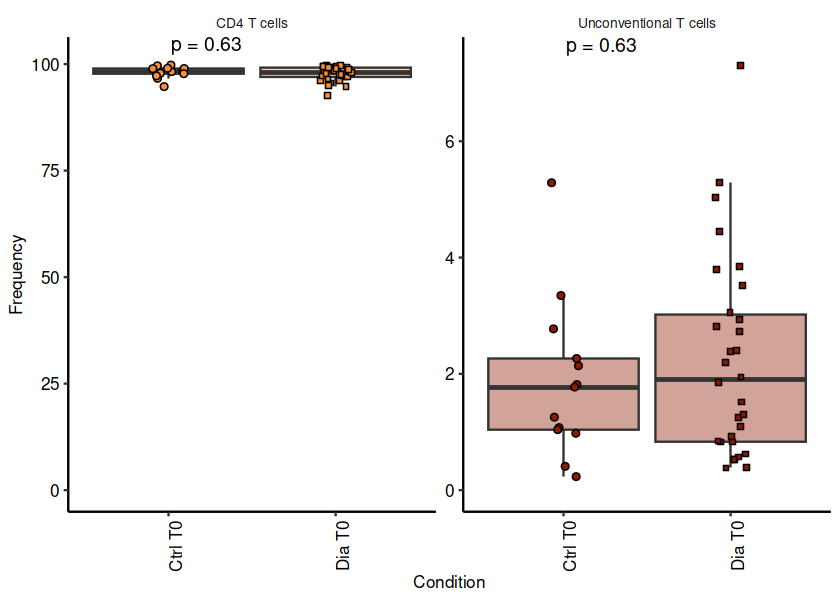

In [13]:
options(repr.plot.width = 7, repr.plot.height = 5)

p1  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition, y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.4, width = 0.9, aes(fill = annotations_l1)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, stackdir='center', aes(fill = annotations_l1, shape = Condition), color = "black") + 
  facet_wrap(~annotations_l1, scales = "free", ncol = 13) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = cd4_full_filt@misc$colors_annotations_l1)+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -1, label = "p.format")+
ggtheme() +
 ylim(0,NA) +
theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()

p1

In [14]:
ggsave("figures/boxplot_cd4_full_filt_1.png", width = 6, height = 8, units = "cm")
ggsave("figures/boxplot_cd4_full_filt_1.svg", width = 6, height = 8, units = "cm")


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


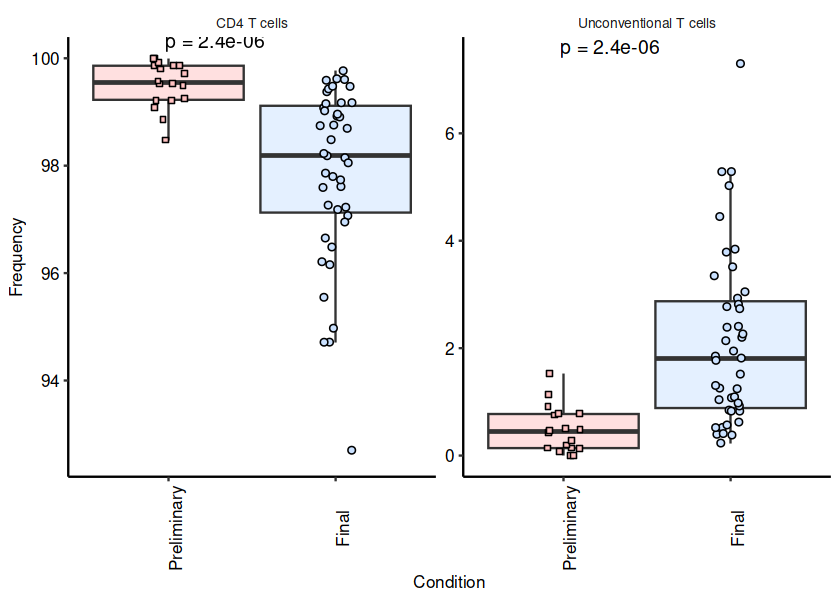

In [15]:
p2  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0"))  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
  ggplot(aes(x = factor(Exp, levels = c("Preliminary", "Final")), y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = Exp)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, stackdir='center', aes(fill = Exp, shape = Exp), color = "black") + 
  facet_wrap(~annotations_l1, scales = "free", ncol = 9) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = c("lightsteelblue1","rosybrown1"))+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -0.7, label = "p.format")+
ggtheme() +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()
p2

In [16]:
ggsave("figures/boxplot_cd4_full_filt_2.png", width = 6, height = 8, units = "cm")
ggsave("figures/boxplot_cd4_full_filt_2.svg", width = 6, height = 8, units = "cm")


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.2, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


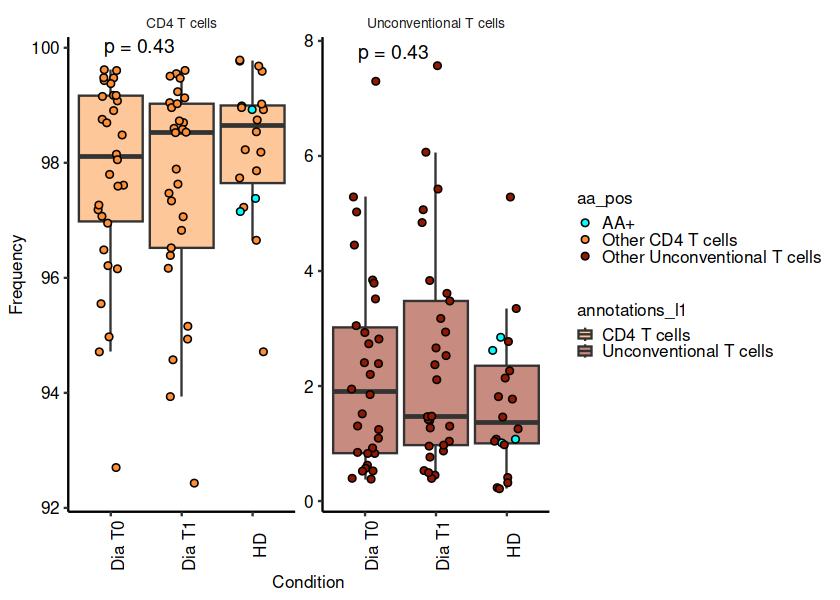

In [20]:
options(repr.plot.width = 7, repr.plot.height = 5)

p3  <- df4  %>% 
mutate(Condition2 = if_else(Disease %in% c("Ctrl", "Pre-Dia"), "HD", Condition))  %>% 
mutate(aa_pos = if_else(Disease %in% c("Pre-Dia"), "AA+", paste("Other", annotations_l1)))  %>% 
filter(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition2, y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = annotations_l1)) +
  scale_fill_manual(values = cd4_full_filt@misc$colors_annotations_l1)+
  new_scale_fill() +
  geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
  geom_jitter(binaxis='y', position=position_jitter(width = 0.2, height = 0), 
  size = 1.5, stackdir='center', aes(fill = aa_pos, shape = aa_pos), color = "black") + 
  scale_fill_manual(values = c("#00ffffff",cd4_full_filt@misc$colors_annotations_l1))+
  
  facet_wrap(~annotations_l1, scales = "free", ncol = 9) +
  ylab("Frequency") +
scale_shape_manual(values = c(21,21,21,21))+
  xlab("Condition") +
  theme_classic() +
ggtheme() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -0.5, label = "p.format")+
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90))
p3

In [21]:
ggsave("figures/boxplot_cd4_full_filt_3.png", width = 13, height = 8, units = "cm")
ggsave("figures/boxplot_cd4_full_filt_3.svg", width = 13, height = 8, units = "cm")


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


### Save freqencies

In [23]:
df4

Sample_ID annotations_l1         freq         Condition  Disease Sex Age 
1   176       CD4 T cells            0.9986072423 Ctrl T0    Ctrl    M    8.0
2   176       Unconventional T cells 0.0013927577 Ctrl T0    Ctrl    M    8.0
3   177       CD4 T cells            1.0000000000 Ctrl T0    Ctrl    F    3.0
4   177       Unconventional T cells 0.0000000000 Ctrl T0    Ctrl    F    3.0
5   178       CD4 T cells            0.9886506936 Dia T0     Dia     M    3.7
6   178       Unconventional T cells 0.0113493064 Dia T0     Dia     M    3.7
7   179       CD4 T cells            0.9948979592 Dia T0     Dia     M    9.4
8   179       Unconventional T cells 0.0051020408 Dia T0     Dia     M    9.4
9   180       CD4 T cells            0.9847645429 Dia T0     Dia     M   16.5
10  180       Unconventional T cells 0.0152354571 Dia T0     Dia     M   16.5
11  181       CD4 T cells            0.9921976593 Dia T0     Dia     F    1.4
12  181       Unconventional T cells 0.0078023407 Dia T0     Dia     F    1.4
13  182       CD4 T cells            0.9987163030 Dia T0     Dia     F    7.8
14  182       Unconventional T cells 0.0012836970 Dia T0     Dia     F    7.8
15  183       CD4 T cells            0.9924528302 Dia T0     Dia     F   11.0
16  183       Unconventional T cells 0.0075471698 Dia T0     Dia     F   11.0
17  184       CD4 T cells            0.9986091794 Ctrl T0    Ctrl    F   15.0
18  184       Unconventional T cells 0.0013908206 Ctrl T0    Ctrl    F   15.0
19  195       CD4 T cells            0.9980119284 Ctrl T0    Ctrl    F   12.4
20  195       Unconventional T cells 0.0019880716 Ctrl T0    Ctrl    F   12.4
21  196       CD4 T cells            0.9992337165 Ctrl T0    Ctrl    F   12.3
22  196       Unconventional T cells 0.0007662835 Ctrl T0    Ctrl    F   12.3
23  197       CD4 T cells            0.9951923077 Ctrl T0    Ctrl    F   12.9
24  197       Unconventional T cells 0.0048076923 Ctrl T0    Ctrl    F   12.9
25  198       CD4 T cells            1.0000000000 Dia T0     Dia     M    4.3
26  198       Unconventional T cells 0.0000000000 Dia T0     Dia     M    4.3
27  199       CD4 T cells            0.9957686883 Dia T0     Dia     M    7.6
28  199       Unconventional T cells 0.0042313117 Dia T0     Dia     M    7.6
29  200       CD4 T cells            0.9908376963 Dia T0     Dia     F    5.9
30  200       Unconventional T cells 0.0091623037 Dia T0     Dia     F    5.9
... ...       ...                    ...          ...        ...     ... ... 
165 435       CD4 T cells            0.985318108  Dia T1     Dia     M   17.1
166 435       Unconventional T cells 0.014681892  Dia T1     Dia     M   17.1
167 436       CD4 T cells            0.991715976  Dia T0     Dia     F   14.3
168 436       Unconventional T cells 0.008284024  Dia T0     Dia     F   14.3
169 437       CD4 T cells            0.985239852  Dia T1     Dia     F   15.3
170 437       Unconventional T cells 0.014760148  Dia T1     Dia     F   15.3
171 438       CD4 T cells            0.997856377  Ctrl T1    Ctrl    F   17.1
172 438       Unconventional T cells 0.002143623  Ctrl T1    Ctrl    F   17.1
173 450       CD4 T cells            0.989881956  Pre-Dia T0 Pre-Dia F   15.0
174 450       Unconventional T cells 0.010118044  Pre-Dia T0 Pre-Dia F   15.0
175 451       CD4 T cells            0.964856230  Dia T0     Dia     F   15.8
176 451       Unconventional T cells 0.035143770  Dia T0     Dia     F   15.8
177 452       CD4 T cells            0.939346812  Dia T1     Dia     F   16.8
178 452       Unconventional T cells 0.060653188  Dia T1     Dia     F   16.8
179 453       CD4 T cells            0.986949429  Dia T0     Dia     F   13.5
180 453       Unconventional T cells 0.013050571  Dia T0     Dia     F   13.5
181 454       CD4 T cells            0.987281399  Dia T1     Dia     F   14.5
182 454       Unconventional T cells 0.012718601  Dia T1     Dia     F   14.5
183 455       CD4 T cells            0.989598811  Ctrl T0    Ctrl    F   12.4
184 455       Unconvention

In [24]:
freq  <- df4  %>% dplyr::select(1:3)
write.csv(freq, "freq_cd4_full_filt.csv", row.names = FALSE)

### Save plot

In [25]:
layout <- "
AA##
AA##
BBBB
CCCC
"

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


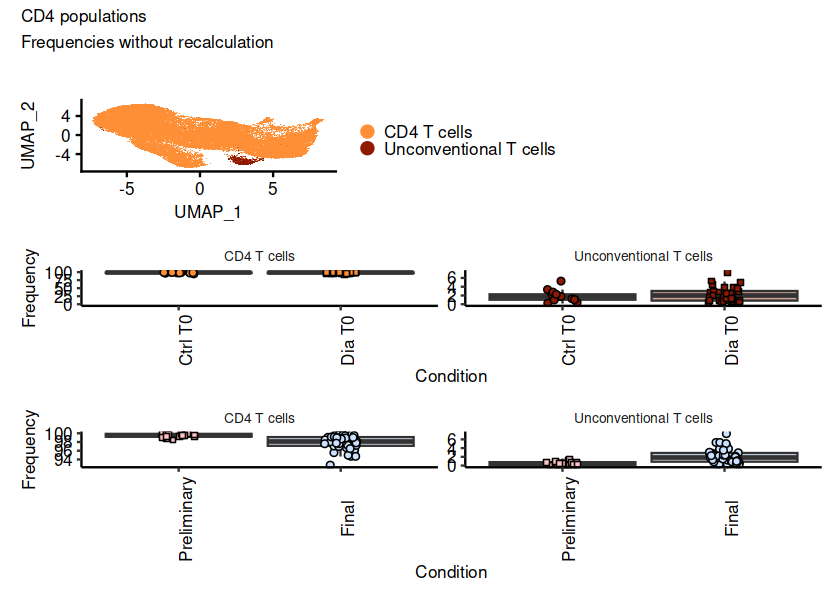

In [26]:
p3  <- dimplot1+p1+p2 + plot_layout(design = layout) + 
plot_annotation(title = "CD4 populations",
                subtitle = "Frequencies without recalculation") & ggtheme()

p3

In [27]:
ggsave(filename="02_Main_populations_CD4.pdf", 
       plot = p3, 
       device = cairo_pdf, 
       width = 210, 
       height = 297, 
       units = "mm")

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


# CD4 subcluster 

In [174]:
cd4_subcluster@meta.data  <- cd4_subcluster@meta.data  %>% 
mutate(annotations_l2 = recode_factor(seurat_clusters, "0" = "Tfh",
                                     "1" = "Naive",
                                     "2" = "Th17",
                                     "3" = "Tcm2",
                                     "4" = "Th1",
                                     "5" = "Tcm1",
                                     "6" = "Treg naive",
                                     "7" = "Th2",
                                     "8" = "Treg memory",
                                     "9" = "ISAGhi",
                                     "10" = "Proliferating",
                                     "11" = "Exhausted",
                                     "12" = "Temra"))

## Cluster composition

In [185]:
cd4_subcluster@misc$cols_annotations_l2  <- c(
     "#e57147ff", # Tfh
               "#f3df6eff", # Naive
               "#D4A6C8", # Th17
               "#ee937aff", # Tcm
               "#ed6378ff", # Th1
                "#febd7cff", # Tcm
               "#ffc82fff", # Treg naive
               "#B07AA1", #Th2
               "orange", # Treg memory
               "rosybrown2", #ISAGhi
               "#D90017", # Proliferating
               "indianred3", # Exhausted
               "#8a1729ff")  # Temra

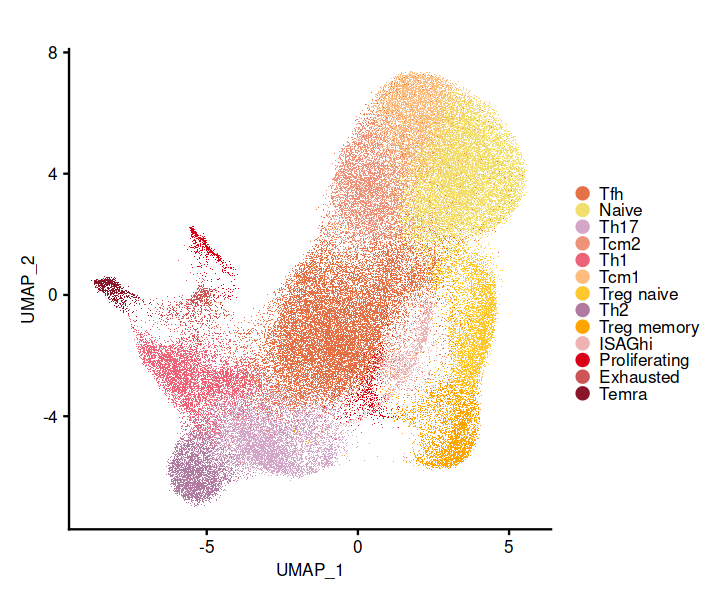

In [184]:
options(repr.plot.width = 6, repr.plot.height = 5)

dimplot1  <- DimPlot(cd4_subcluster, label = F, raster = T, group.by = "annotations_l2",
       cols = cd4_subcluster@misc$cols_annotations_l2) + ggtheme() + ggtitle("")
dimplot1

In [189]:
levels = c("Tfh","Naive","Th17","Tcm2","Th1","Tcm1",
           "Treg naive","Th2","Treg memory","ISAGhi","Proliferating","Exhausted","Temra")

In [186]:
options(repr.plot.width = 15, repr.plot.height = 5)

seurat_meta_data <- cd4_subcluster@meta.data

# Create grouped dataframe, calculate the frequencies of clusters
df4 <- seurat_meta_data %>% 
  group_by(Sample_ID, annotations_l2) %>% 
  summarise(n = n()) %>% 
  unique() %>% 
  mutate(freq = n / sum(n))  %>% 
dplyr::select(-n)  %>% 
ungroup   %>% 
pivot_wider(names_from = "annotations_l2", values_from = "freq", values_fill = 0)   %>% 
pivot_longer(!Sample_ID, values_to = "freq", names_to = "annotations_l2")
# Control - all sums should be one
# df4 %>% group_by(Sample_ID) %>% summarise(sum = sum(freq))

# As we've lost non-grouping variables, let's join them back
md_to_join <- seurat_meta_data %>% 
  dplyr::select(Sample_ID, Condition, Disease, Sex, Age, Age_group, Patient_ID, Time, Experiment_ID) %>% 
  unique()

df4  <- left_join(df4, md_to_join)

# The final plot

p0  <- df4 %>% 
  ggplot(aes(x = Condition, y = freq)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.7, width = 0.9, aes(fill = Condition)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, shape = 21, stackdir='center', aes(fill = Condition), color = "black") + 
  facet_wrap(~annotations_l2, scales = "free", ncol = 6) +
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
 ylim(0,NA) +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text.x = element_text(angle = 90))

`summarise()` has grouped output by 'Sample_ID'. You can override using the
`.groups` argument.
Joining with `by = join_by(Sample_ID)`
Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


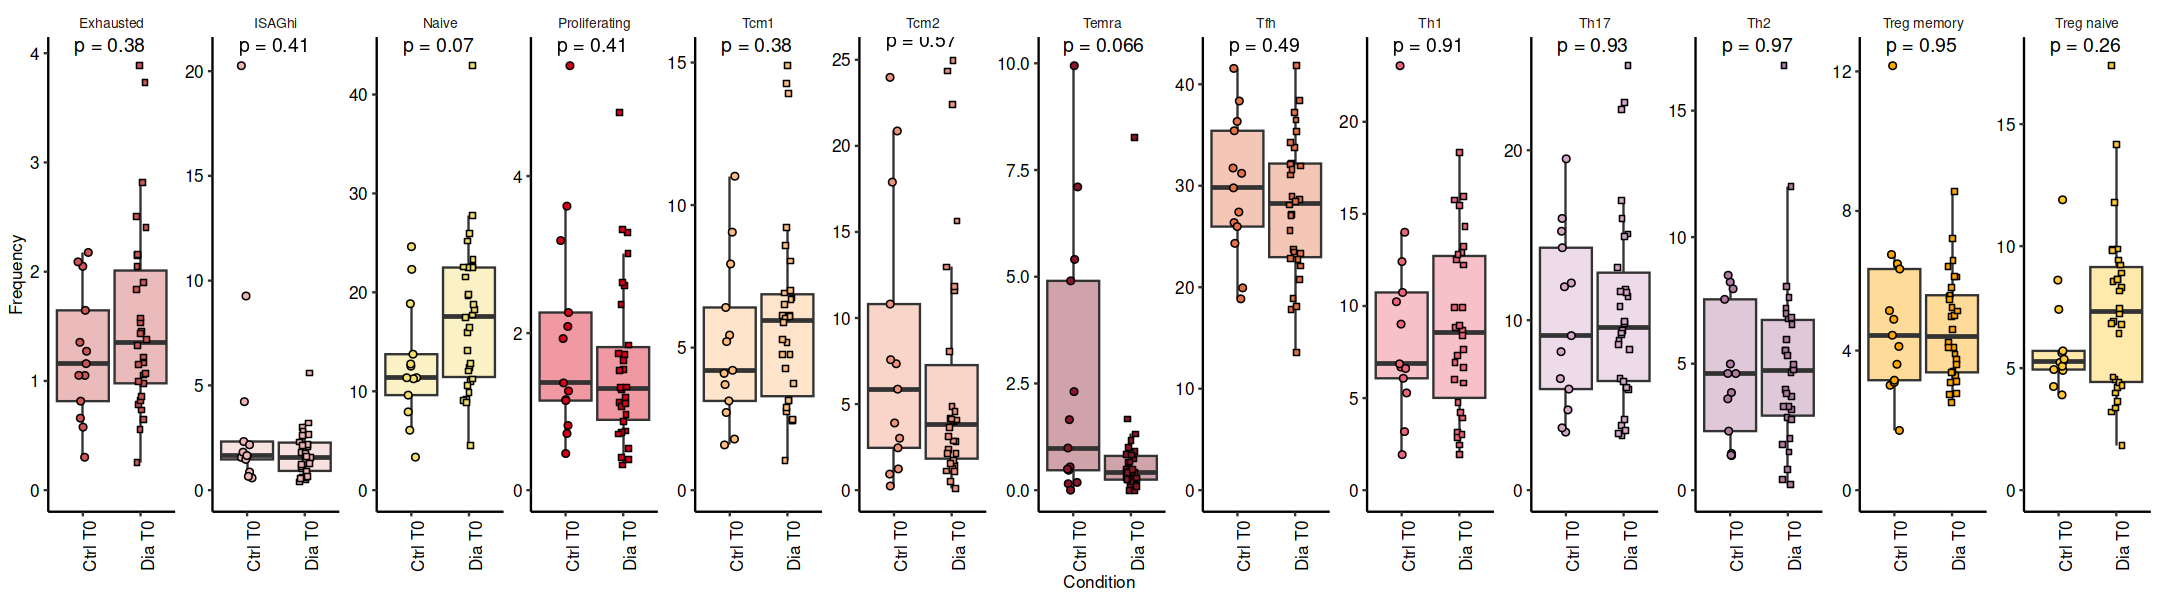

In [192]:
options(repr.plot.width = 18, repr.plot.height = 5)

p1  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition, y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.4, width = 0.9, aes(fill = factor(annotations_l2, levels = levels))) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, stackdir='center', aes(fill = factor(annotations_l2, levels = levels), shape = Condition), color = "black") + 
  facet_wrap(~annotations_l2, scales = "free", ncol = 13) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = cd4_subcluster@misc$cols_annotations_l2)+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -1, label = "p.format")+
ggtheme() +
 ylim(0,NA) +
theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()

p1

In [193]:
ggsave("figures/boxplot_cd4_subcluster_1.png", width = 24, height = 8, units = "cm")
ggsave("figures/boxplot_cd4_subcluster_1.svg", width = 24, height = 8, units = "cm")


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


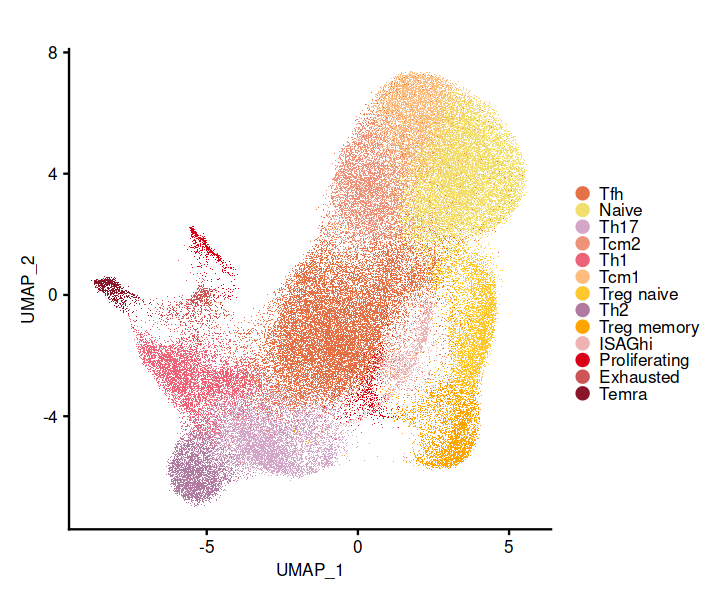

In [194]:
options(repr.plot.width = 6, repr.plot.height = 5)

dimplot1  <- DimPlot(cd4_subcluster, label = F, raster = T, group.by = "annotations_l2",
       cols = cd4_subcluster@misc$cols_annotations_l2) + ggtheme() + ggtitle("")
dimplot1

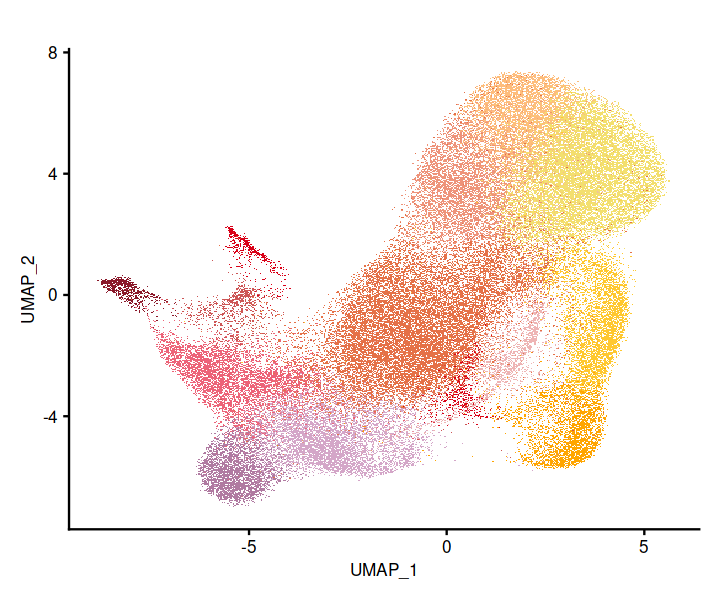

In [195]:
dimplot1 + NoLegend()
ggsave("dimplot_cd4_subcluster.png", width = 12, height = 12, units = "cm")
ggsave("dimplot_cd4_subcluster.svg", width = 12, height = 12, units = "cm")

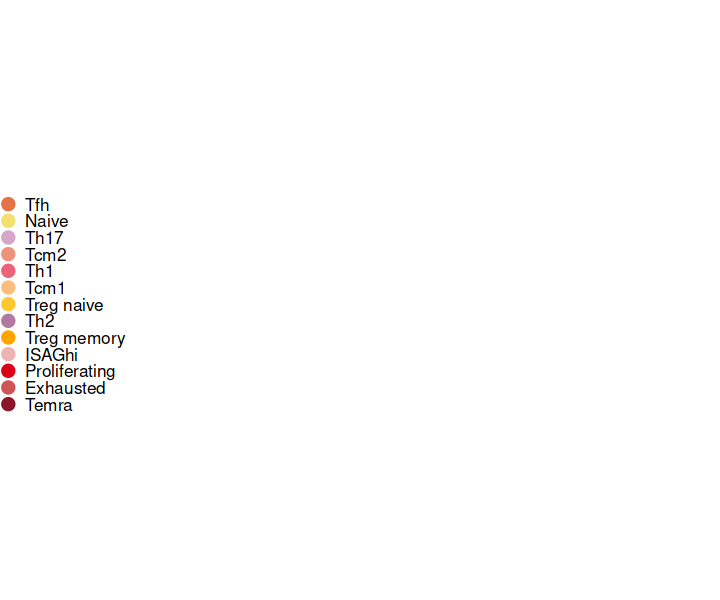

In [202]:
my_legend <- get_legend(dimplot1)
my_legend <- as_ggplot(my_legend) + ggtheme()
my_legend
ggsave("legend_dimplot_cd4_subcluster.png", width = 12, height = 12, units = "cm")
ggsave("legend_dimplot_cd4_subcluster.svg", width = 12, height = 12, units = "cm")

Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


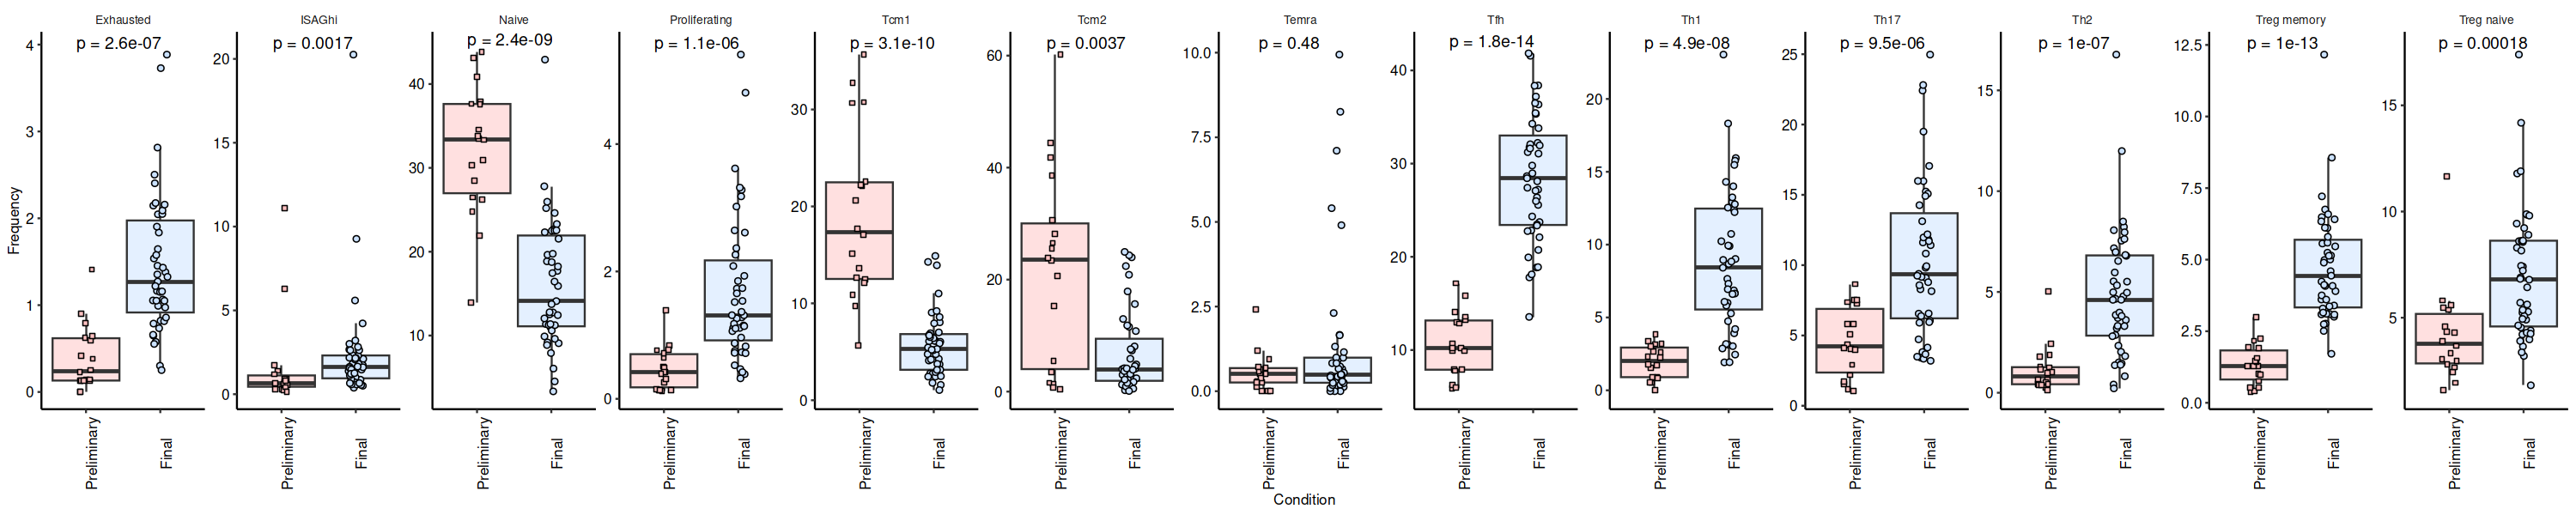

In [224]:
p2  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0"))  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
  ggplot(aes(x = factor(Exp, levels = c("Preliminary", "Final")), y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = Exp)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, stackdir='center', aes(fill = Exp, shape = Exp), color = "black") + 
  facet_wrap(~annotations_l2, scales = "free", ncol = 13) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = c("lightsteelblue1","rosybrown1"))+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -0.5, label = "p.format")+
ggtheme() +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()
p2

In [225]:
ggsave("figures/boxplot_cd4_subcluster_2.png", width = 24, height = 8, units = "cm")
ggsave("figures/boxplot_cd4_subcluster_2.svg", width = 24, height = 8, units = "cm")

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


In [226]:
levels2  <- c("AA+", paste("Other", levels))

Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.2, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


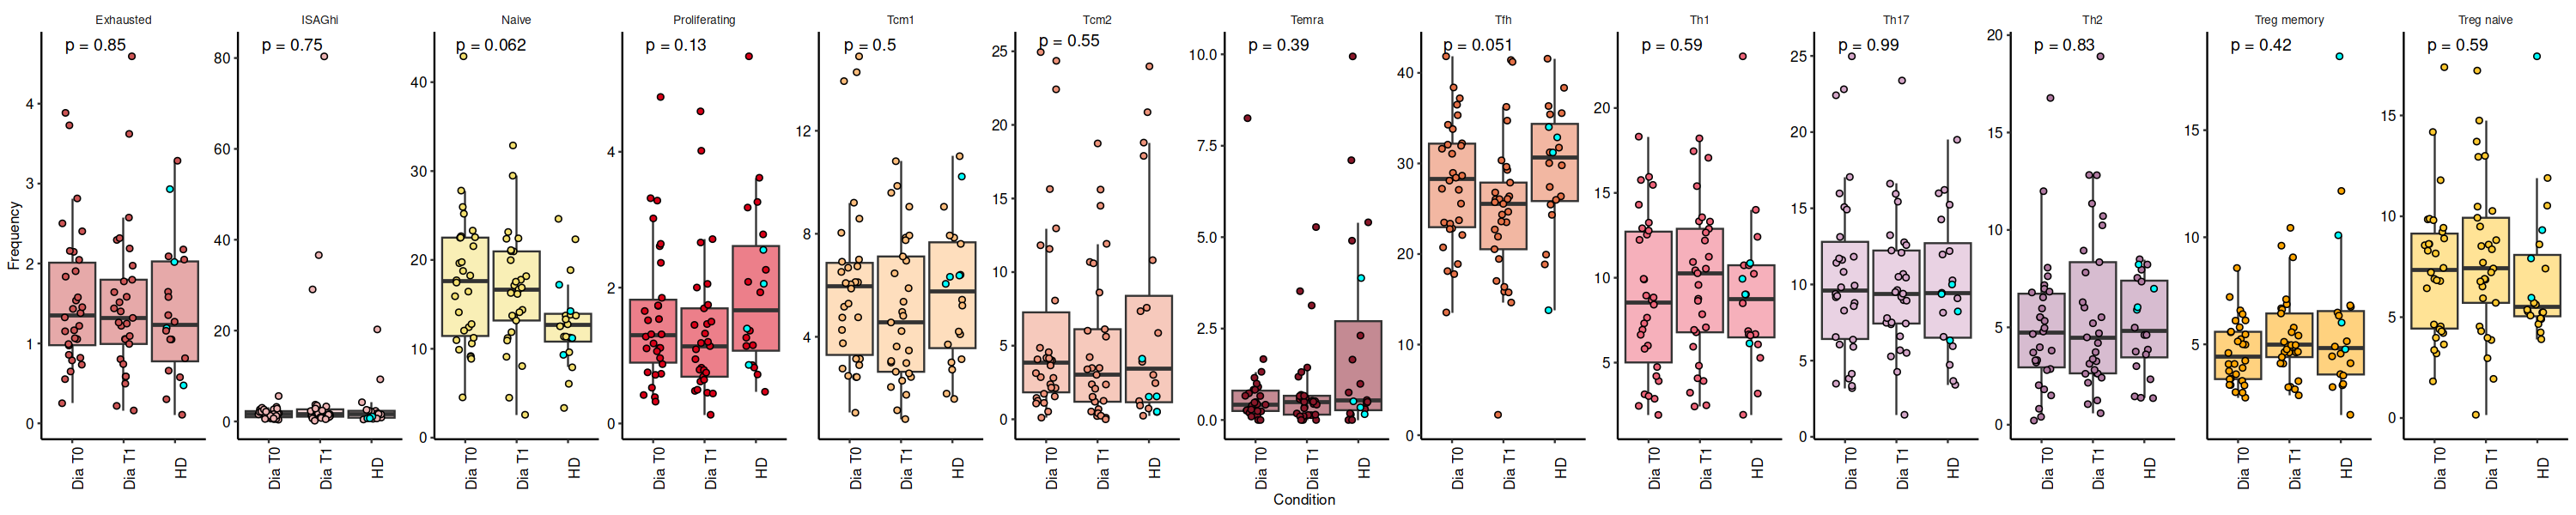

In [229]:
options(repr.plot.width = 25, repr.plot.height = 5)

p3  <- df4  %>% 
mutate(Condition2 = if_else(Disease %in% c("Ctrl", "Pre-Dia"), "HD", Condition))  %>% 
mutate(aa_pos = if_else(Disease %in% c("Pre-Dia"), "AA+", paste("Other", annotations_l2)))  %>% 
filter(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition2, y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = factor(annotations_l2, levels = levels))) +
  scale_fill_manual(values = c(cd4_subcluster@misc$cols_annotations_l2))+
  new_scale_fill() +
  geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
  geom_jitter(binaxis='y', position=position_jitter(width = 0.2, height = 0), 
  size = 1.5, shape = 21, stackdir='center', aes(fill = factor(aa_pos, levels = levels2))) + 
  scale_fill_manual(values = c("#00ffffff",cd4_subcluster@misc$cols_annotations_l2))+
   facet_wrap(~annotations_l2, scales = "free", ncol = 13) +
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggtheme() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -0.5, label = "p.format")+
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90))
p3 + NoLegend()

In [230]:
ggsave("figures/boxplot_cd4_subcluster_3.png", width = 35, height = 8, units = "cm")
ggsave("figures/boxplot_cd4_subcluster_3.svg", width = 35, height = 8, units = "cm")


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


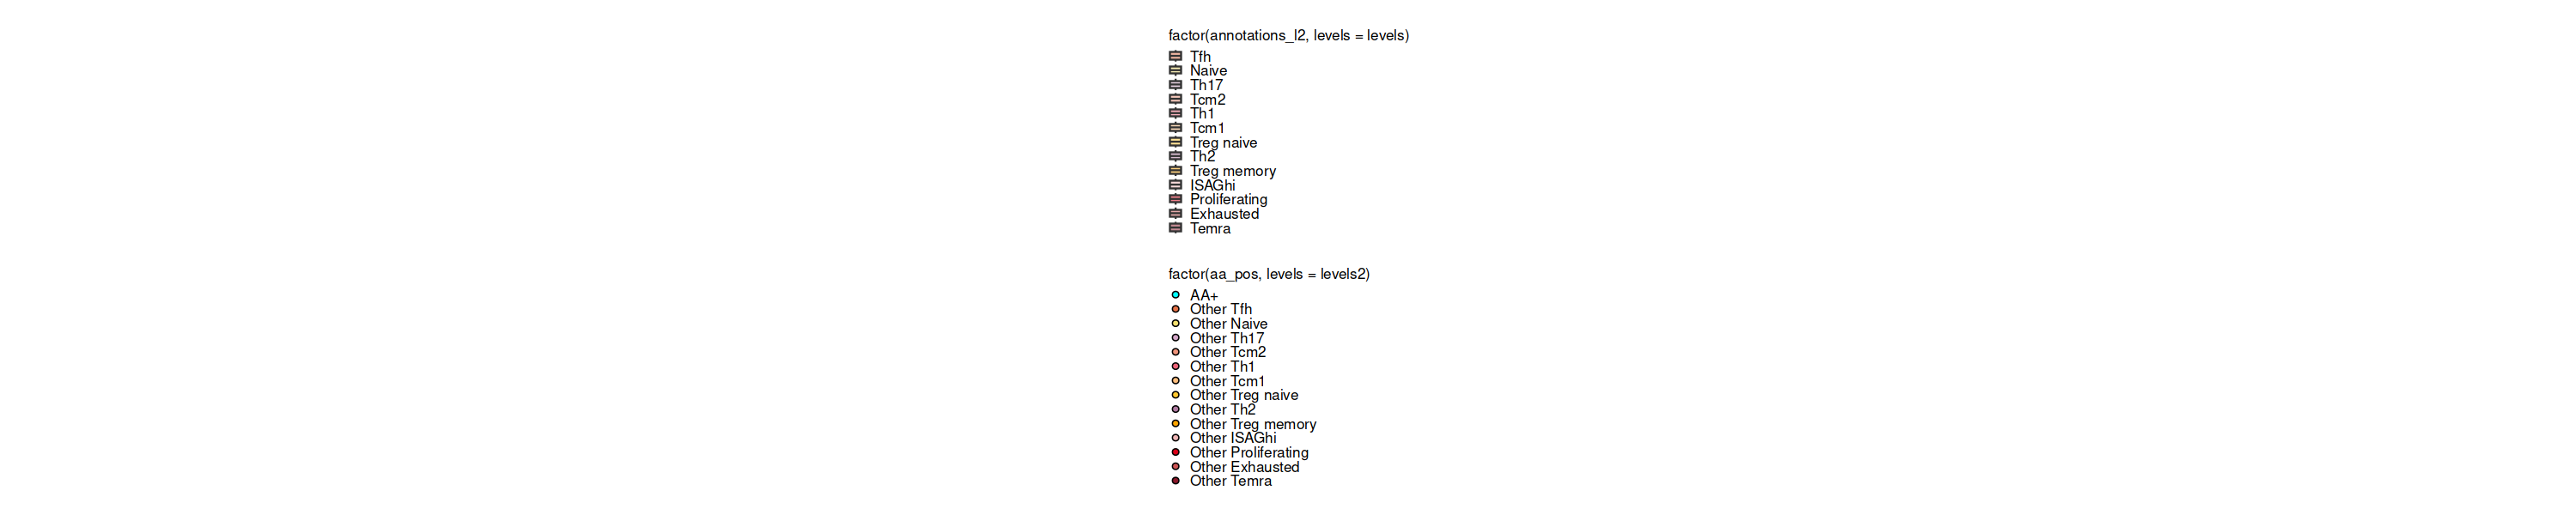

In [231]:
my_legend <- get_legend(p3)
my_legend <- as_ggplot(my_legend) + ggtheme()
my_legend
ggsave("legend_dimplot_cd4_subcluster_3.png", width = 12, height = 12, units = "cm")
ggsave("legend_dimplot_cd4_subcluster_3.svg", width = 12, height = 12, units = "cm")

### Save freqencies

In [232]:
df4

Sample_ID annotations_l2 freq        Condition  Disease Sex Age Age_group
1    176       Tfh            0.171548117 Ctrl T0    Ctrl    M   8.0 2        
2    176       Naive          0.262203626 Ctrl T0    Ctrl    M   8.0 2        
3    176       Th17           0.086471409 Ctrl T0    Ctrl    M   8.0 2        
4    176       Tcm2           0.013947001 Ctrl T0    Ctrl    M   8.0 2        
5    176       Th1            0.026499303 Ctrl T0    Ctrl    M   8.0 2        
6    176       Tcm1           0.327754533 Ctrl T0    Ctrl    M   8.0 2        
7    176       Treg naive     0.055788006 Ctrl T0    Ctrl    M   8.0 2        
8    176       Th2            0.012552301 Ctrl T0    Ctrl    M   8.0 2        
9    176       Treg memory    0.019525802 Ctrl T0    Ctrl    M   8.0 2        
10   176       ISAGhi         0.013947001 Ctrl T0    Ctrl    M   8.0 2        
11   176       Proliferating  0.008368201 Ctrl T0    Ctrl    M   8.0 2        
12   176       Exhausted      0.001394700 Ctrl T0    Ctrl    M   8.0 2        
13   176       Temra          0.000000000 Ctrl T0    Ctrl    M   8.0 2        
14   177       Tfh            0.157961783 Ctrl T0    Ctrl    F   3.0 1        
15   177       Naive          0.335031847 Ctrl T0    Ctrl    F   3.0 1        
16   177       Th17           0.043312102 Ctrl T0    Ctrl    F   3.0 1        
17   177       Tcm2           0.007643312 Ctrl T0    Ctrl    F   3.0 1        
18   177       Th1            0.022929936 Ctrl T0    Ctrl    F   3.0 1        
19   177       Tcm1           0.356687898 Ctrl T0    Ctrl    F   3.0 1        
20   177       Treg naive     0.030573248 Ctrl T0    Ctrl    F   3.0 1        
21   177       Th2            0.012738854 Ctrl T0    Ctrl    F   3.0 1        
22   177       Treg memory    0.010191083 Ctrl T0    Ctrl    F   3.0 1        
23   177       ISAGhi         0.008917197 Ctrl T0    Ctrl    F   3.0 1        
24   177       Proliferating  0.007643312 Ctrl T0    Ctrl    F   3.0 1        
25   177       Exhausted      0.001273885 Ctrl T0    Ctrl    F   3.0 1        
26   177       Temra          0.005095541 Ctrl T0    Ctrl    F   3.0 1        
27   178       Tfh            0.102040816 Dia T0     Dia     M   3.7 1        
28   178       Naive          0.345663265 Dia T0     Dia     M   3.7 1        
29   178       Th17           0.015306122 Dia T0     Dia     M   3.7 1        
30   178       Tcm2           0.255102041 Dia T0     Dia     M   3.7 1        
...  ...       ...            ...         ...        ...     ... ... ...      
1232 458       ISAGhi         0.011075949 Pre-Dia T0 Pre-Dia F   8.1 2        
1233 458       Proliferating  0.020569620 Pre-Dia T0 Pre-Dia F   8.1 2        
1234 458       Exhausted      0.004746835 Pre-Dia T0 Pre-Dia F   8.1 2        
1235 458       Temra          0.001582278 Pre-Dia T0 Pre-Dia F   8.1 2        
1236 459       Tfh            0.312111801 Pre-Dia T0 Pre-Dia M   9.7 2        
1237 459       Naive          0.093167702 Pre-Dia T0 Pre-Dia M   9.7 2        
1238 459       Th17           0.082298137 Pre-Dia T0 Pre-Dia M   9.7 2        
1239 459       Tcm2           0.015527950 Pre-Dia T0 Pre-Dia M   9.7 2        
1240 459       Th1            0.099378882 Pre-Dia T0 Pre-Dia M   9.7 2        
1241 459       Tcm1           0.060559006 Pre-Dia T0 Pre-Dia M   9.7 2        
1242 459       Treg naive     0.093167702 Pre-Dia T0 Pre-Dia M   9.7 2        
1243 459       Th2            0.059006211 Pre-Dia T0 Pre-Dia M   9.7 2        
1244 459       Treg memory    0.100931677 Pre-Dia T0 Pre-Dia M   9.7 2        
1245 459       ISAGhi         0.010869565 Pre-Dia T0 Pre-Dia M   9.7 2        
1246 459       Proliferating  0.013975155 Pre-Dia T0 Pre-Dia M   9.7 2        
1247 459       Exhausted      0.020186335 Pre-Dia T0 Pre-Dia M   9.7 2        
1248 459       Temra          0.038819876 Pre-Dia T0 Pre-Dia M   9.7 2        
1249 460       Tfh            0.137931034 Pre-Dia T0 Pre-Dia M   9.5 2        
1250 460       Naive          0.112068966 Pre-Dia T0 Pr

In [233]:
freq  <- df4  %>% dplyr::select(1:3)
write.csv(freq, "freq_cd4_subcluster.csv", row.names = FALSE)

# Treg subcluster 

## Cluster composition

In [236]:
treg_subcluster  <- FindNeighbors(treg_subcluster)
treg_subcluster  <- FindClusters(treg_subcluster, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9771
Number of edges: 297281

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8000
Number of communities: 7
Elapsed time: 1 seconds


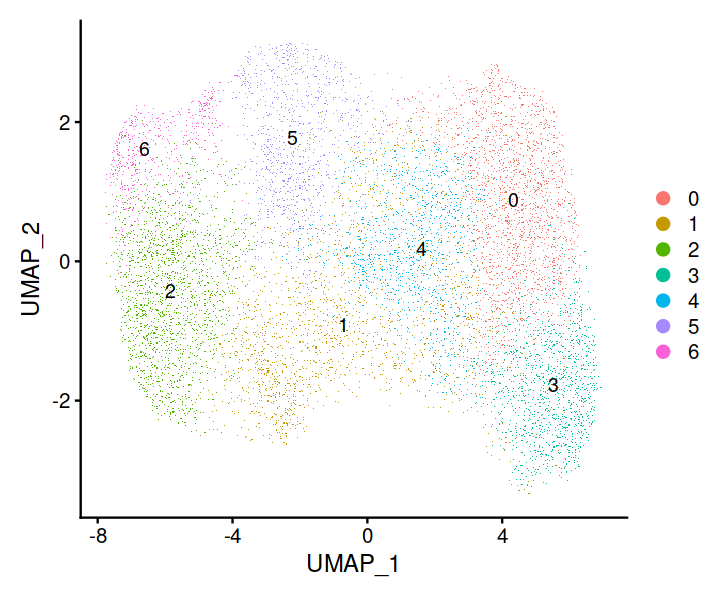

In [237]:
options(repr.plot.width = 6, repr.plot.height = 5)

dimplot1  <- DimPlot(treg_subcluster, label = T, raster = T) 
dimplot1

In [275]:
treg_subcluster@meta.data  <- treg_subcluster@meta.data  %>% 
mutate(annotations_l3 = recode_factor(seurat_clusters, 
                                     "0" = "Naive",
                                     "1" = "Memory TNFRSF4+ KLRB1+",
                                     "2" = "Activated HLA+ CCR10+",
                                     "3" = "Dysfunctional",
                                     "4" = "Naive",
                                     "5" = "Memory GZMK",
                                     "6" = "Activated ISAGhi"))

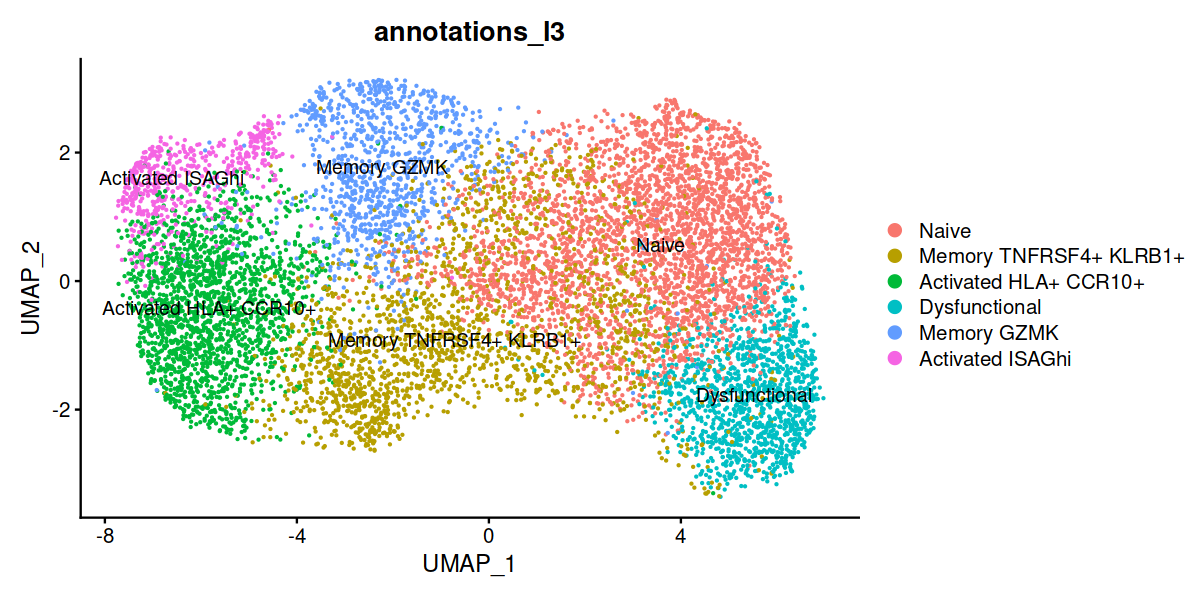

In [276]:
options(repr.plot.width = 10, repr.plot.height = 5)

DimPlot(treg_subcluster, label = T, group.by = "annotations_l3")

In [281]:
treg_subcluster@misc$cols_annotations_l3  <- c(
    "#eeedd0ff",
    "gold",
    "goldenrod",
    "#a9be3cff",
"yellow",
"#ffb601ff")

In [291]:
levels = c("Naive",
          "Memory TNFRSF4+ KLRB1+",
           "Activated HLA+ CCR10+",
           "Dysfunctional",
           "Memory GZMK",
           "Activated ISAGhi")

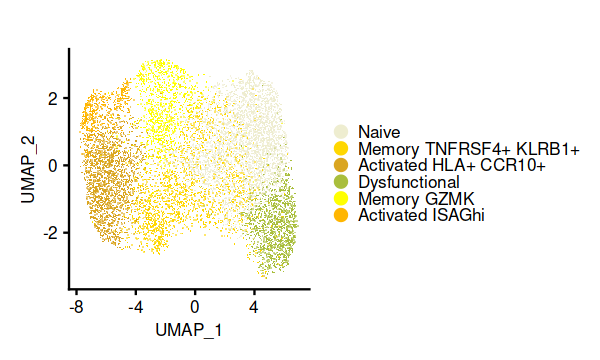

In [411]:
options(repr.plot.width = 5, repr.plot.height = 3)

dimplot1  <- DimPlot(treg_subcluster, label = F, raster = T, group.by = "annotations_l3",
                    cols = treg_subcluster@misc$cols_annotations_l3, pt.size = 2) + 
ggtheme() + 
ggtitle("")
dimplot1

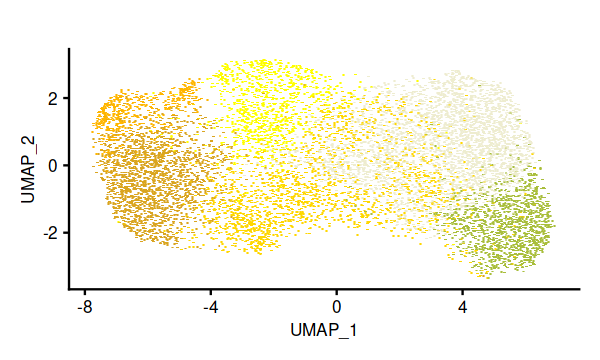

In [284]:
dimplot1 + NoLegend()
ggsave("dimplot_treg_subcluster.png", width = 12, height = 12, units = "cm")
ggsave("dimplot_treg_subcluster.svg", width = 12, height = 12, units = "cm")

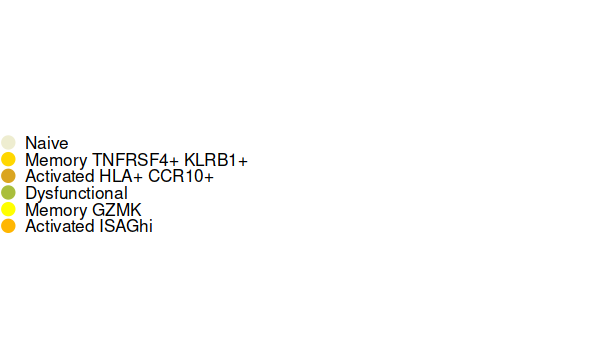

In [412]:
my_legend <- get_legend(dimplot1)
my_legend <- as_ggplot(my_legend) + ggtheme()
my_legend
ggsave("legend_dimplot_treg_subcluster.png", width = 12, height = 12, units = "cm")
ggsave("legend_dimplot_treg_subcluster.svg", width = 12, height = 12, units = "cm")

In [10]:
options(repr.plot.width = 15, repr.plot.height = 5)

seurat_meta_data <- treg_subcluster@meta.data

# Create grouped dataframe, calculate the frequencies of clusters
df4 <- seurat_meta_data %>% 
  group_by(Sample_ID, annotations_l3) %>% 
  summarise(n = n()) %>% 
  unique() %>% 
  mutate(freq = n / sum(n))  %>% 
dplyr::select(-n)  %>% 
ungroup   %>% 
pivot_wider(names_from = "annotations_l3", values_from = "freq", values_fill = 0)   %>% 
pivot_longer(!Sample_ID, values_to = "freq", names_to = "annotations_l3")
# Control - all sums should be one
# df4 %>% group_by(Sample_ID) %>% summarise(sum = sum(freq))

# As we've lost non-grouping variables, let's join them back
md_to_join <- seurat_meta_data %>% 
  dplyr::select(Sample_ID, Condition, Disease, Sex, Age, Age_group, Patient_ID, Time, Experiment_ID) %>% 
  unique()

df4  <- left_join(df4, md_to_join)

# The final plot

p0  <- df4 %>% 
  ggplot(aes(x = Condition, y = freq)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.7, width = 0.9, aes(fill = Condition)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, shape = 21, stackdir='center', aes(fill = Condition), color = "black") + 
  facet_wrap(~annotations_l3, scales = "free", ncol = 6) +
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
 ylim(0,NA) +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text.x = element_text(angle = 90))

ERROR: [1m[33mError[39m in `group_by()`:[22m
[1m[22m[33m![39m Must group by variables found in `.data`.
[31mx[39m Column `annotations_l3` is not found.


In [11]:
p0

ERROR: Error in eval(expr, envir, enclos): object 'p0' not found


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


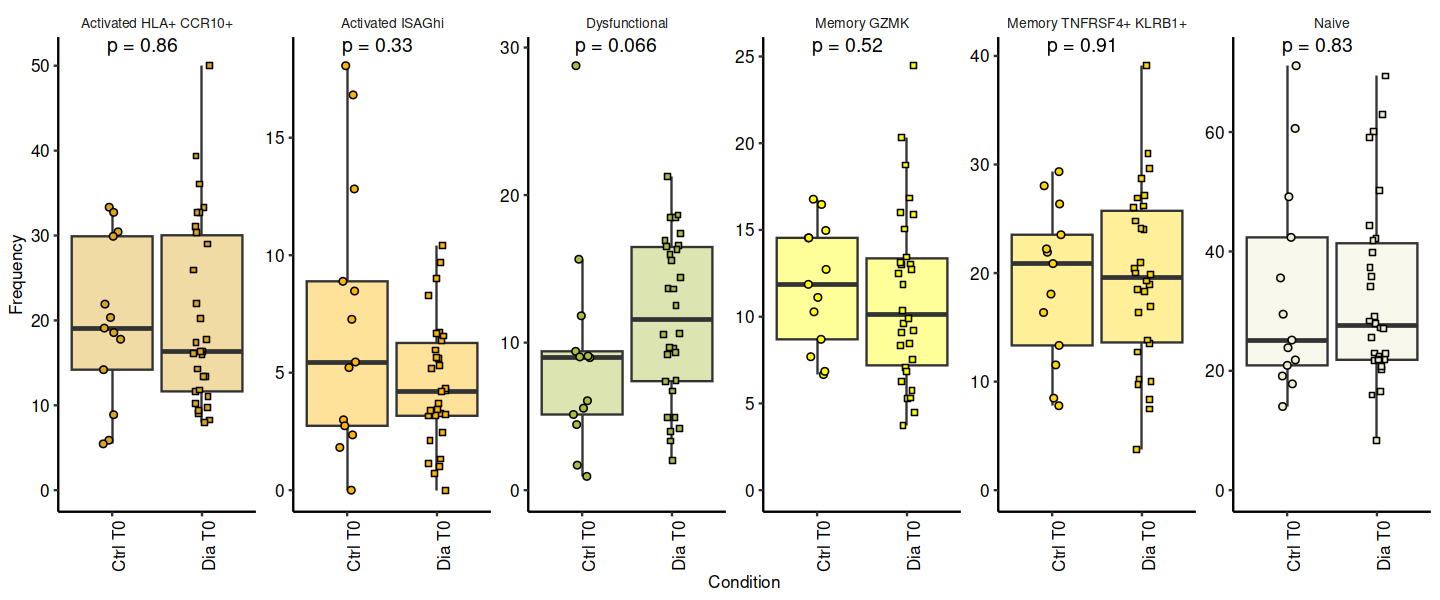

In [296]:
options(repr.plot.width = 12, repr.plot.height = 5)

p1  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition, y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.4, width = 0.9, aes(fill = factor(annotations_l3, levels = levels))) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, stackdir='center', aes(fill = factor(annotations_l3, levels = levels), shape = Condition), color = "black") + 
  facet_wrap(~annotations_l3, scales = "free", ncol = 13) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = treg_subcluster@misc$cols_annotations_l3) +
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -1, label = "p.format")+
ggtheme() +
 ylim(0,NA) +
theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()

p1

In [176]:
ggsave("figures/boxplot_treg_subcluster_1.png", width = 16, height = 8, units = "cm")
ggsave("figures/boxplot_treg_subcluster_1.svg", width = 16, height = 8, units = "cm")


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


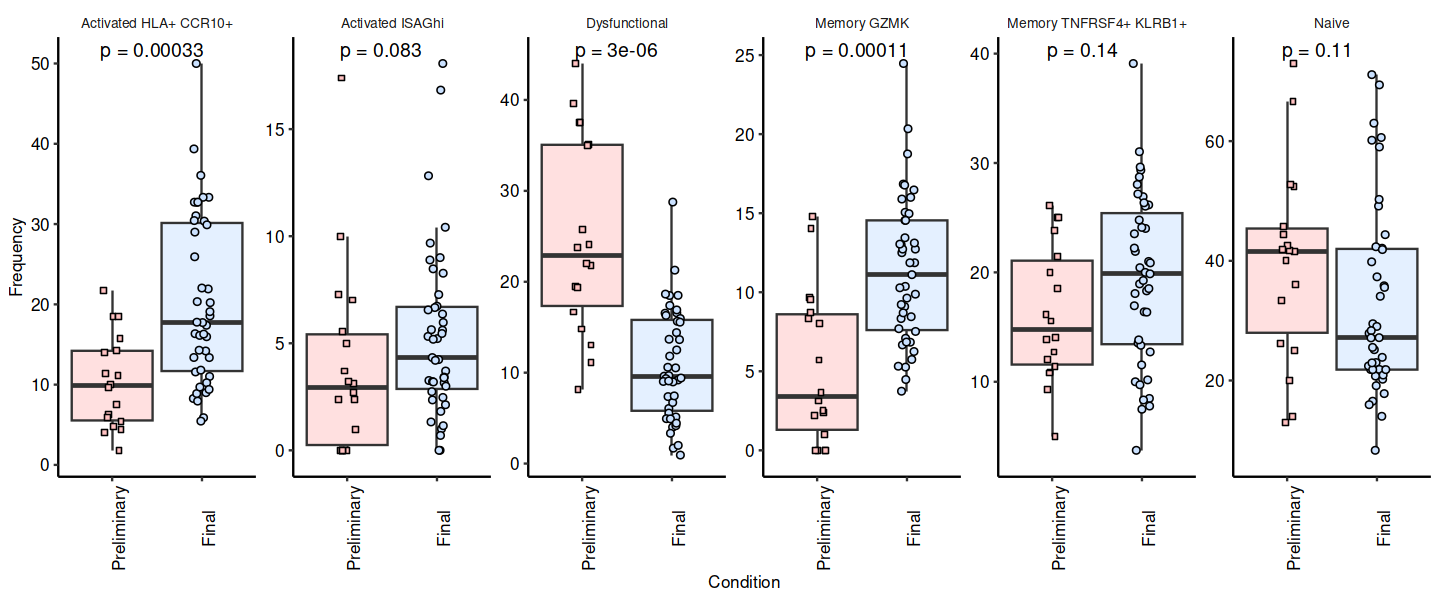

In [297]:
p2  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0"))  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
  ggplot(aes(x = factor(Exp, levels = c("Preliminary", "Final")), y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = Exp)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, stackdir='center', aes(fill = Exp, shape = Exp), color = "black") + 
  facet_wrap(~annotations_l3, scales = "free", ncol = 9) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = c("lightsteelblue1","rosybrown1"))+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -0.5, label = "p.format")+
ggtheme() +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()
p2

In [298]:
ggsave("figures/boxplot_treg_subcluster_2.png", width = 16, height = 8, units = "cm")
ggsave("figures/boxplot_treg_subcluster_2.svg", width = 16, height = 8, units = "cm")


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


In [299]:
levels2  <- c("AA+", paste("Other", levels))

Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.2, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


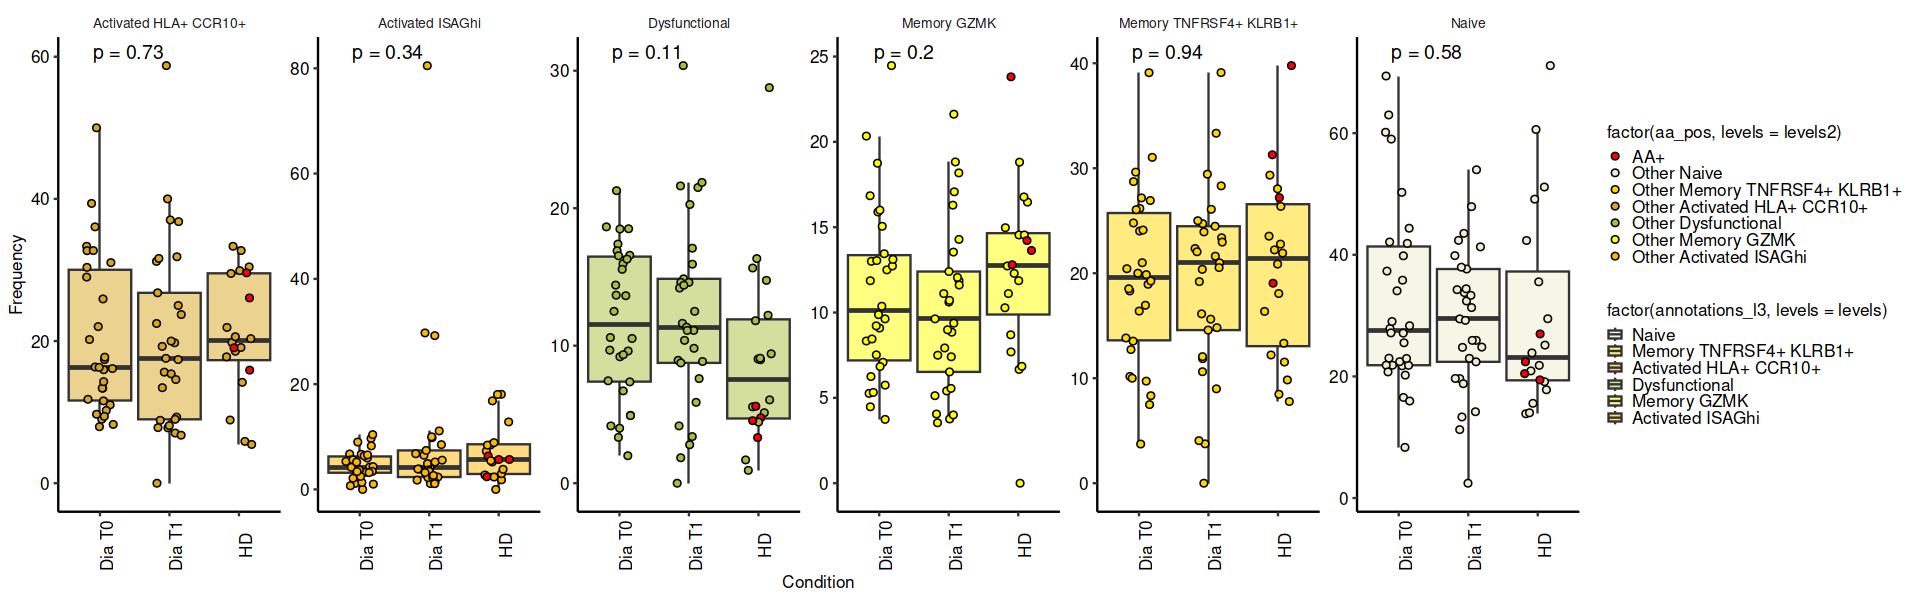

In [301]:
options(repr.plot.width = 16, repr.plot.height = 5)

p3  <- df4  %>% 
mutate(Condition2 = if_else(Disease %in% c("Ctrl", "Pre-Dia"), "HD", Condition))  %>% 
mutate(aa_pos = if_else(Disease %in% c("Pre-Dia"), "AA+", paste("Other", annotations_l3)))  %>% 
filter(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition2, y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = factor(annotations_l3, levels = levels))) +
  scale_fill_manual(values = c(treg_subcluster@misc$cols_annotations_l3))+
  new_scale_fill() +
  geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
  geom_jitter(binaxis='y', position=position_jitter(width = 0.2, height = 0), 
  size = 1.5, stackdir='center', shape = 21, aes(fill = factor(aa_pos, levels = levels2))) + 
  scale_fill_manual(values = c("#00ffffff",treg_subcluster@misc$cols_annotations_l3))+
  
  facet_wrap(~annotations_l3, scales = "free", ncol = 9) +
  ylab("Frequency") +
scale_shape_manual(values = c(21,21,21,21,21,21,21,21,21))+
  xlab("Condition") +
  theme_classic() +
ggtheme() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -0.5, label = "p.format")+
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90))
p3

In [384]:
ggsave("figures/boxplot_treg_subcluster_3.png", width = 40, height = 8, units = "cm")
ggsave("figures/boxplot_treg_subcluster_3.svg", width = 40, height = 8, units = "cm")

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


### Save freqencies

In [269]:
df4

Sample_ID annotations_l3                                freq       
1   148       Cytotoxic CD16hi CD56lo CD27- IFNG+ GZMK-     0.50000000 
2   148       gd T cells                                    0.11538462 
3   148       Intermediate CD16int CD56lo CD27+ IFNG+ GZMK+ 0.30769231 
4   148       Regulatory CD16lo CD56hi CD27+ IFNG- GZMK+    0.07692308 
5   148       Proliferating                                 0.00000000 
6   148       ISAGhi                                        0.00000000 
7   149       Cytotoxic CD16hi CD56lo CD27- IFNG+ GZMK-     0.57142857 
8   149       gd T cells                                    0.19047619 
9   149       Intermediate CD16int CD56lo CD27+ IFNG+ GZMK+ 0.14285714 
10  149       Regulatory CD16lo CD56hi CD27+ IFNG- GZMK+    0.09523810 
11  149       Proliferating                                 0.00000000 
12  149       ISAGhi                                        0.00000000 
13  150       Cytotoxic CD16hi CD56lo CD27- IFNG+ GZMK-     0.66666667 
14  150       gd T cells                                    0.00000000 
15  150       Intermediate CD16int CD56lo CD27+ IFNG+ GZMK+ 0.00000000 
16  150       Regulatory CD16lo CD56hi CD27+ IFNG- GZMK+    0.33333333 
17  150       Proliferating                                 0.00000000 
18  150       ISAGhi                                        0.00000000 
19  151       Cytotoxic CD16hi CD56lo CD27- IFNG+ GZMK-     0.33333333 
20  151       gd T cells                                    0.00000000 
21  151       Intermediate CD16int CD56lo CD27+ IFNG+ GZMK+ 0.50000000 
22  151       Regulatory CD16lo CD56hi CD27+ IFNG- GZMK+    0.16666667 
23  151       Proliferating                                 0.00000000 
24  151       ISAGhi                                        0.00000000 
25  152       Cytotoxic CD16hi CD56lo CD27- IFNG+ GZMK-     0.44444444 
26  152       gd T cells                                    0.55555556 
27  152       Intermediate CD16int CD56lo CD27+ IFNG+ GZMK+ 0.00000000 
28  152       Regulatory CD16lo CD56hi CD27+ IFNG- GZMK+    0.00000000 
29  152       Proliferating                                 0.00000000 
30  152       ISAGhi                                        0.00000000 
... ...       ...                                           ...        
547 445       Cytotoxic CD16hi CD56lo CD27- IFNG+ GZMK-     0.492481203
548 445       gd T cells                                    0.169172932
549 445       Intermediate CD16int CD56lo CD27+ IFNG+ GZMK+ 0.233082707
550 445       Regulatory CD16lo CD56hi CD27+ IFNG- GZMK+    0.097744361
551 445       Proliferating                                 0.003759398
552 445       ISAGhi                                        0.003759398
553 446       Cytotoxic CD16hi CD56lo CD27- IFNG+ GZMK-     0.188888889
554 446       gd T cells                                    0.111111111
555 446       Intermediate CD16int CD56lo CD27+ IFNG+ GZMK+ 0.155555556
556 446       Regulatory CD16lo CD56hi CD27+ IFNG- GZMK+    0.244444444
557 446       Proliferating                                 0.033333333
558 446       ISAGhi                                        0.266666667
559 447       Cytotoxic CD16hi CD56lo CD27- IFNG+ GZMK-     0.403669725
560 447       gd T cells                                    0.192660550
561 447       Intermediate CD16int CD56lo CD27+ IFNG+ GZMK+ 0.229357798
562 447       Regulatory CD16lo CD56hi CD27+ IFNG- GZMK+    0.146788991
563 447       Proliferating                                 0.027522936
564 447       ISAGhi                                        0.000000000
565 448       Cytotoxic CD16hi CD56lo CD27- IFNG+ GZMK-     0.438202247
566 448       gd T cells                                    0.078651685
567 448       Intermediate CD16int CD56lo CD27+ IFNG+ GZMK+ 0.359550562
568 448       Regulatory CD16lo CD56hi CD27+ IFNG- GZMK+    0.089887640
569 448       Proliferating                                 0.022471910
570 448       ISAGhi                        

In [270]:
freq  <- df4  %>% dplyr::select(1:3)
write.csv(freq, "freq_treg_subcluster.csv", row.names = FALSE)

## Teff subcluster

## Cluster composition

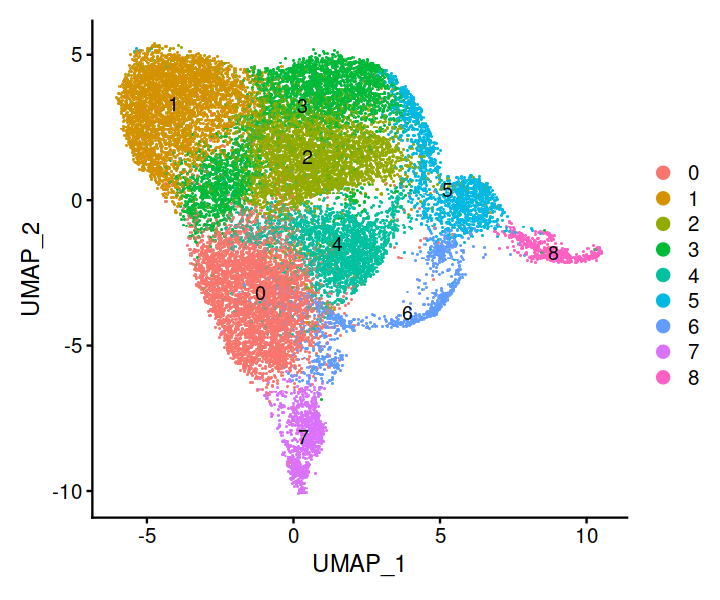

In [302]:
options(repr.plot.width = 6, repr.plot.height = 5)

dimplot1  <- DimPlot(teff_subcluster, label = T, raster = T, pt.size = 2) 
dimplot1

In [457]:
teff_subcluster@meta.data  <- teff_subcluster@meta.data  %>% 
mutate(annotations_l3 = recode_factor(seurat_clusters, 
                                     "0" = "Th1 cells",
                                     "1" = "Th2 cells",
                                     "2" = "Memory CCR7 SELL TCF7",
                                     "3" = "Memory CCRhi CD49neg HLA+",
                                     "4" = "Th17 cells",
                                     "5" = "Exhausted",
                                     "6" = "Unconventional GZMhi IL10 IL19",
                                     "7" = "Temra",
                                     "8" = "Proliferating"))

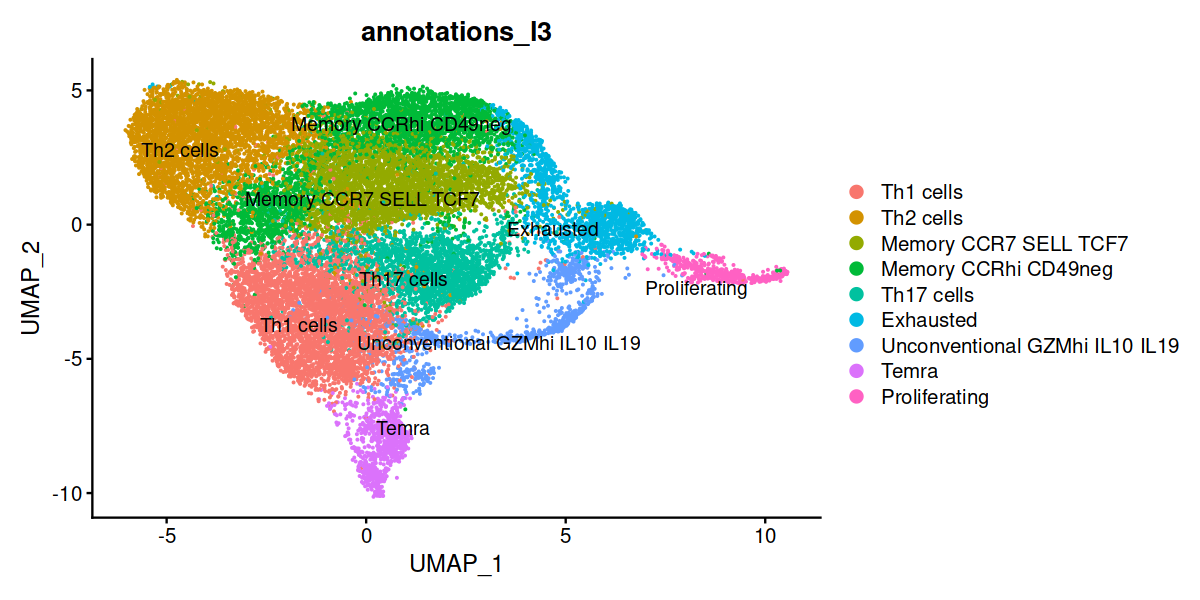

In [350]:
options(repr.plot.width = 10, repr.plot.height = 5)

DimPlot(teff_subcluster, label = T, group.by = "annotations_l3", repel = T)

In [453]:
teff_subcluster@misc$cols_annotations_l3  <- c(
     "#ed6378ff", # Th1
     "#B07AA1", #Th2
     "#f497abff" , #Mem CCR7
    "#ea2349ff",  #Mem CCR10
    "#D4A6C8", # Th17
    "indianred3", # Exhausted
     "#ffc8c1ff",  #Unconventional
   "#8a1729ff",  # Temra
    "#D90017") # Proliferating)

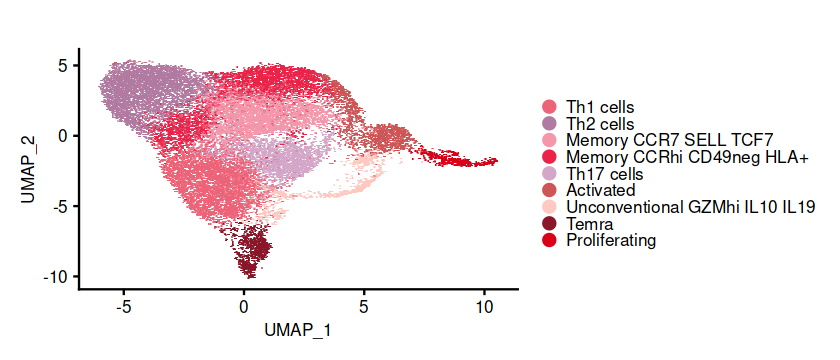

In [454]:
options(repr.plot.width = 7, repr.plot.height = 3)

dimplot1  <- DimPlot(teff_subcluster, label = F, raster = T, group.by = "annotations_l3",
                    cols = teff_subcluster@misc$cols_annotations_l3, pt.size = 2) + 
ggtheme() + 
ggtitle("")
dimplot1

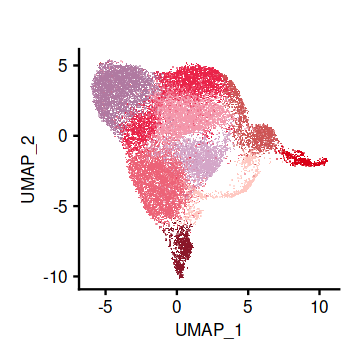

In [437]:
options(repr.plot.width = 3, repr.plot.height = 3)

dimplot1 + NoLegend()
ggsave("dimplot_teff_subcluster.png", width = 12, height = 12, units = "cm")
ggsave("dimplot_teff_subcluster.svg", width = 12, height = 12, units = "cm")

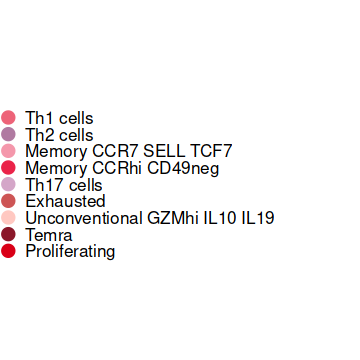

In [438]:
my_legend <- get_legend(dimplot1)
my_legend <- as_ggplot(my_legend) + ggtheme()
my_legend
ggsave("legend_dimplot_teff_subcluster.png", width = 12, height = 12, units = "cm")
ggsave("legend_dimplot_teff_subcluster.svg", width = 12, height = 12, units = "cm")

In [458]:
levels = c("Th1 cells","Th2 cells","Memory CCR7 SELL TCF7", "Memory CCRhi CD49neg HLA+",
                                     "Th17 cells",
                                     "Exhausted",
                                     "Unconventional GZMhi IL10 IL19",
                                     "Temra",
                                    "Proliferating")

In [459]:
options(repr.plot.width = 15, repr.plot.height = 5)

seurat_meta_data <- teff_subcluster@meta.data

# Create grouped dataframe, calculate the frequencies of clusters
df4 <- seurat_meta_data %>% 
  group_by(Sample_ID, annotations_l3) %>% 
  summarise(n = n()) %>% 
  unique() %>% 
  mutate(freq = n / sum(n))  %>% 
dplyr::select(-n)  %>% 
ungroup   %>% 
pivot_wider(names_from = "annotations_l3", values_from = "freq", values_fill = 0)   %>% 
pivot_longer(!Sample_ID, values_to = "freq", names_to = "annotations_l3")
# Control - all sums should be one
# df4 %>% group_by(Sample_ID) %>% summarise(sum = sum(freq))

# As we've lost non-grouping variables, let's join them back
md_to_join <- seurat_meta_data %>% 
  dplyr::select(Sample_ID, Condition, Disease, Sex, Age, Age_group, Patient_ID, Time, Experiment_ID) %>% 
  unique()

df4  <- left_join(df4, md_to_join)

# The final plot

p0  <- df4 %>% 
  ggplot(aes(x = Condition, y = freq)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.7, width = 0.9, aes(fill = Condition)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, shape = 21, stackdir='center', aes(fill = Condition), color = "black") + 
  facet_wrap(~annotations_l3, scales = "free", ncol = 6) +
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
 ylim(0,NA) +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text.x = element_text(angle = 90))

`summarise()` has grouped output by 'Sample_ID'. You can override using the
`.groups` argument.
Joining with `by = join_by(Sample_ID)`
Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


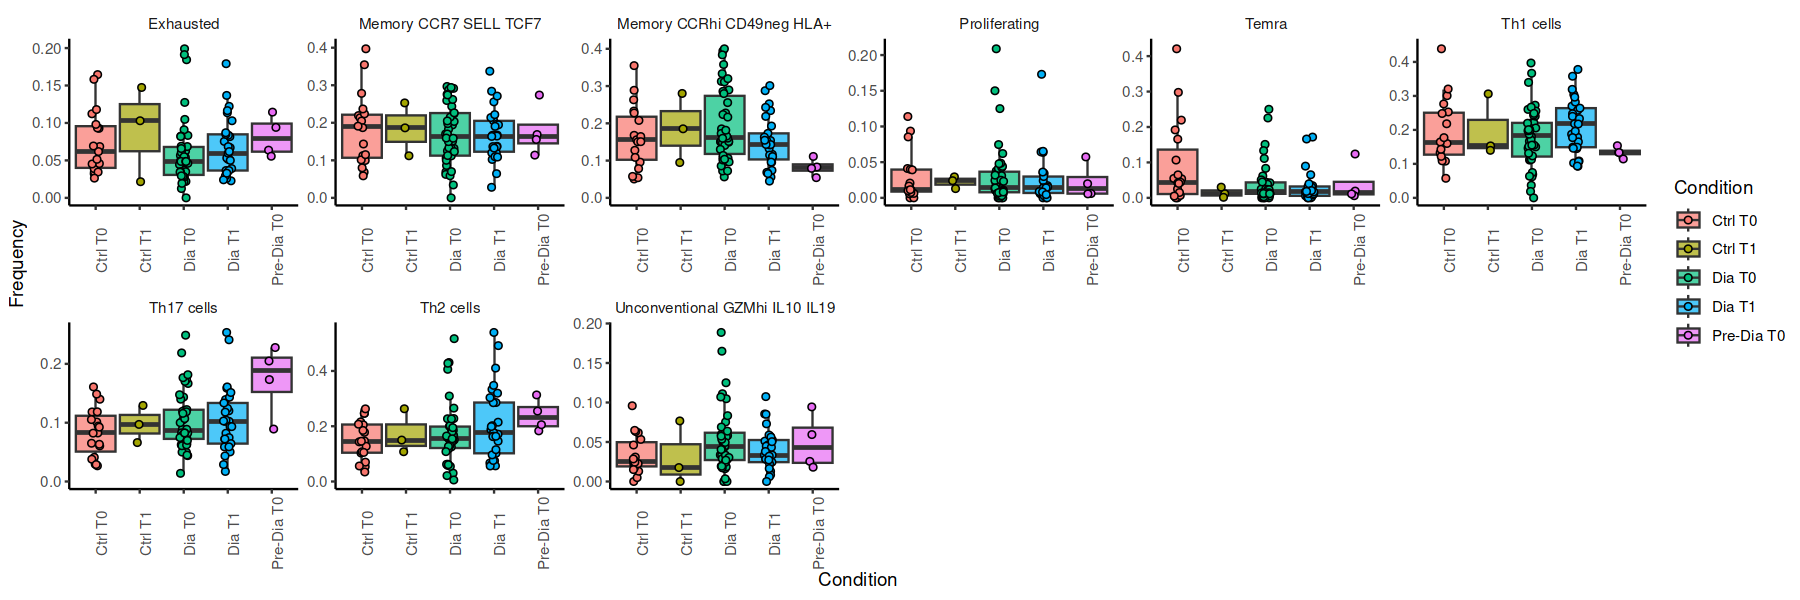

In [460]:
p0

Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


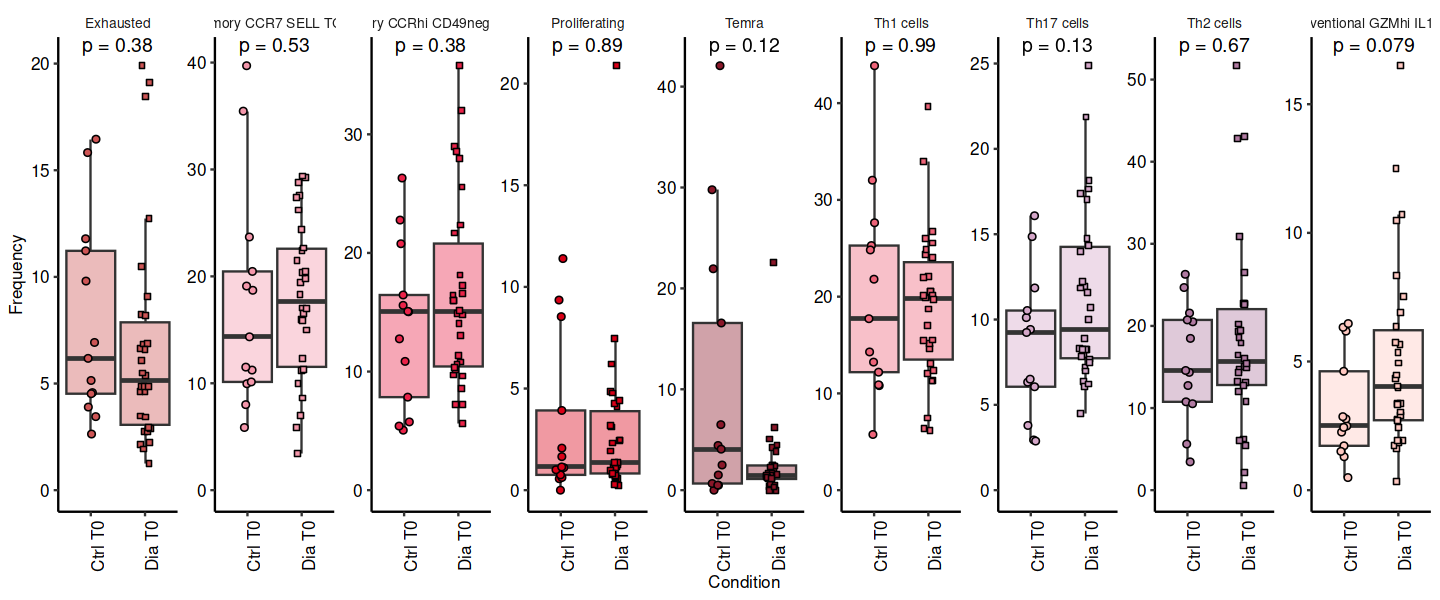

In [461]:
options(repr.plot.width = 12, repr.plot.height = 5)

p1  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition, y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.4, width = 0.9, aes(fill = factor(annotations_l3, levels = levels))) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, stackdir='center', aes(fill = factor(annotations_l3, levels = levels), shape = Condition), color = "black") + 
  facet_wrap(~annotations_l3, scales = "free", ncol = 13) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = teff_subcluster@misc$cols_annotations_l3) +
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -1, label = "p.format")+
ggtheme() +
 ylim(0,NA) +
theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()

p1

In [462]:
ggsave("figures/boxplot_teff_subcluster_1.png", width = 16, height = 8, units = "cm")
ggsave("figures/boxplot_teff_subcluster_1.svg", width = 16, height = 8, units = "cm")


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


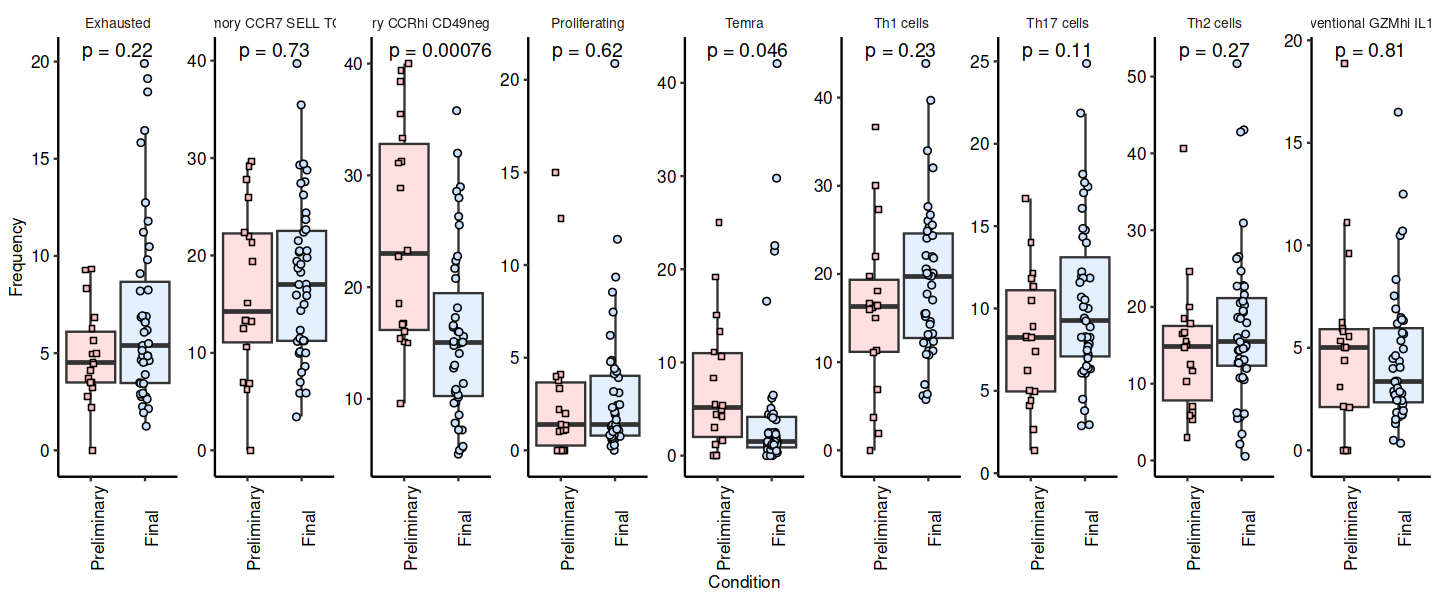

In [463]:
p2  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0"))  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
  ggplot(aes(x = factor(Exp, levels = c("Preliminary", "Final")), y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = Exp)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, stackdir='center', aes(fill = Exp, shape = Exp), color = "black") + 
  facet_wrap(~annotations_l3, scales = "free", ncol = 9) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = c("lightsteelblue1","rosybrown1"))+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -0.5, label = "p.format")+
ggtheme() +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()
p2

In [464]:
ggsave("figures/boxplot_teff_subcluster_2.png", width = 16, height = 8, units = "cm")
ggsave("figures/boxplot_teff_subcluster_2.svg", width = 16, height = 8, units = "cm")


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


In [465]:
levels2  <- c("AA+", paste("Other", levels))

Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.2, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


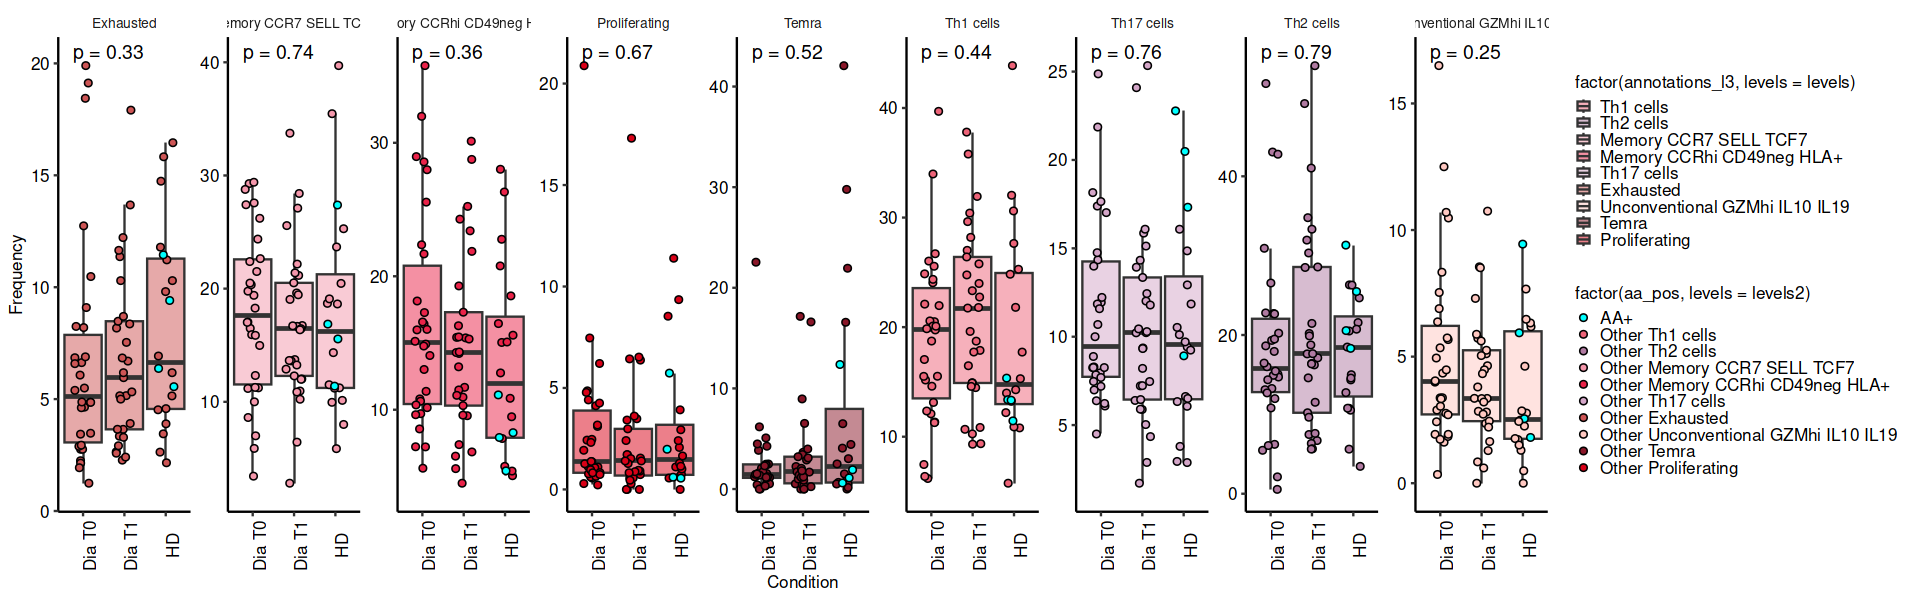

In [467]:
options(repr.plot.width = 16, repr.plot.height = 5)

p3  <- df4  %>% 
mutate(Condition2 = if_else(Disease %in% c("Ctrl", "Pre-Dia"), "HD", Condition))  %>% 
mutate(aa_pos = if_else(Disease %in% c("Pre-Dia"), "AA+", paste("Other", annotations_l3)))  %>% 
filter(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition2, y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = factor(annotations_l3, levels = levels))) +
  scale_fill_manual(values = c(teff_subcluster@misc$cols_annotations_l3))+
  new_scale_fill() +
  geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
  geom_jitter(binaxis='y', position=position_jitter(width = 0.2, height = 0), 
  size = 1.5, stackdir='center', shape = 21, aes(fill = factor(aa_pos, levels = levels2))) + 
  scale_fill_manual(values = c("#00ffffff",teff_subcluster@misc$cols_annotations_l3))+
  
  facet_wrap(~annotations_l3, scales = "free", ncol = 9) +
  ylab("Frequency") +
scale_shape_manual(values = c(21,21,21,21,21,21,21,21,21))+
  xlab("Condition") +
  theme_classic() +
ggtheme() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -0.5, label = "p.format")+
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90))
p3

In [468]:
ggsave("figures/boxplot_teff_subcluster_3.png", width = 40, height = 8, units = "cm")
ggsave("figures/boxplot_teff_subcluster_3.svg", width = 40, height = 8, units = "cm")

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


### Save freqencies

In [469]:
df4

Sample_ID annotations_l3                 freq        Condition  Disease Sex
1   176       Th1 cells                      0.11340206  Ctrl T0    Ctrl    M  
2   176       Th2 cells                      0.10309278  Ctrl T0    Ctrl    M  
3   176       Memory CCR7 SELL TCF7          0.27835052  Ctrl T0    Ctrl    M  
4   176       Memory CCRhi CD49neg HLA+      0.28865979  Ctrl T0    Ctrl    M  
5   176       Th17 cells                     0.08247423  Ctrl T0    Ctrl    M  
6   176       Exhausted                      0.09278351  Ctrl T0    Ctrl    M  
7   176       Unconventional GZMhi IL10 IL19 0.03092784  Ctrl T0    Ctrl    M  
8   176       Proliferating                  0.01030928  Ctrl T0    Ctrl    M  
9   176       Temra                          0.00000000  Ctrl T0    Ctrl    M  
10  177       Th1 cells                      0.16438356  Ctrl T0    Ctrl    F  
11  177       Th2 cells                      0.17808219  Ctrl T0    Ctrl    F  
12  177       Memory CCR7 SELL TCF7          0.21917808  Ctrl T0    Ctrl    F  
13  177       Memory CCRhi CD49neg HLA+      0.23287671  Ctrl T0    Ctrl    F  
14  177       Th17 cells                     0.04109589  Ctrl T0    Ctrl    F  
15  177       Exhausted                      0.06849315  Ctrl T0    Ctrl    F  
16  177       Unconventional GZMhi IL10 IL19 0.00000000  Ctrl T0    Ctrl    F  
17  177       Proliferating                  0.04109589  Ctrl T0    Ctrl    F  
18  177       Temra                          0.05479452  Ctrl T0    Ctrl    F  
19  178       Th1 cells                      0.03703704  Dia T0     Dia     M  
20  178       Th2 cells                      0.18518519  Dia T0     Dia     M  
21  178       Memory CCR7 SELL TCF7          0.25925926  Dia T0     Dia     M  
22  178       Memory CCRhi CD49neg HLA+      0.18518519  Dia T0     Dia     M  
23  178       Th17 cells                     0.07407407  Dia T0     Dia     M  
24  178       Exhausted                      0.03703704  Dia T0     Dia     M  
25  178       Unconventional GZMhi IL10 IL19 0.11111111  Dia T0     Dia     M  
26  178       Proliferating                  0.00000000  Dia T0     Dia     M  
27  178       Temra                          0.11111111  Dia T0     Dia     M  
28  179       Th1 cells                      0.01886792  Dia T0     Dia     M  
29  179       Th2 cells                      0.15094340  Dia T0     Dia     M  
30  179       Memory CCR7 SELL TCF7          0.13207547  Dia T0     Dia     M  
... ...       ...                            ...         ...        ...     ...
844 457       Unconventional GZMhi IL10 IL19 0.028571429 Ctrl T0    Ctrl    F  
845 457       Proliferating                  0.011428571 Ctrl T0    Ctrl    F  
846 457       Temra                          0.165714286 Ctrl T0    Ctrl    F  
847 458       Th1 cells                      0.114457831 Pre-Dia T0 Pre-Dia F  
848 458       Th2 cells                      0.313253012 Pre-Dia T0 Pre-Dia F  
849 458       Memory CCR7 SELL TCF7          0.168674699 Pre-Dia T0 Pre-Dia F  
850 458       Memory CCRhi CD49neg HLA+      0.054216867 Pre-Dia T0 Pre-Dia F  
851 458       Th17 cells                     0.204819277 Pre-Dia T0 Pre-Dia F  
852 458       Exhausted                      0.114457831 Pre-Dia T0 Pre-Dia F  
853 458       Unconventional GZMhi IL10 IL19 0.018072289 Pre-Dia T0 Pre-Dia F  
854 458       Proliferating                  0.006024096 Pre-Dia T0 Pre-Dia F  
855 458       Temra                          0.006024096 Pre-Dia T0 Pre-Dia F  
856 459       Th1 cells                      0.153465347 Pre-Dia T0 Pre-Dia M  
857 459       Th2 cells                      0.183168317 Pre-Dia T0 Pre-Dia M  
858 459       Memory CCR7 SELL TCF7          0.113861386 Pre-Dia T0 Pre-Dia M  
859 459       Memory CCRhi CD49neg HLA+      0.079207921 Pre-Dia T0 Pre-Dia M  
860 459       Th17 cells                     0.173267327 Pre-Dia T0 Pre-Dia M  
861 459       Exhausted                      0.094059406 Pre-Dia T0 Pre-Dia M  
862 

In [470]:
freq  <- df4  %>% dplyr::select(1:3)
write.csv(freq, "freq_cd4_teff_subcluster.csv", row.names = FALSE)

In [484]:
saveRDS(teff_subcluster, "data/processed/cd4_teff_subcluster.rds")

## Unconventional CD4 T cells

## Cluster composition

In [4]:
cd4_unc  <- readRDS("data/processed/cd4_unc_subcluster.rds") 

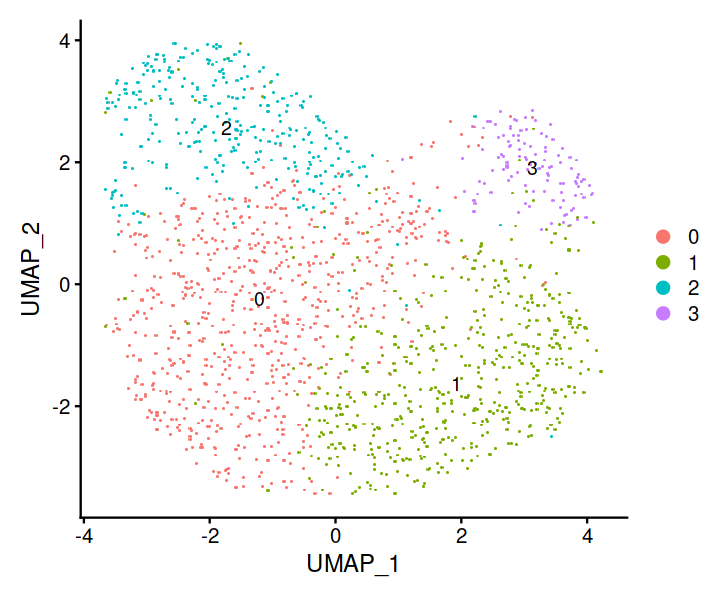

In [5]:
options(repr.plot.width = 6, repr.plot.height = 5)

dimplot1  <- DimPlot(cd4_unc, label = T, raster = T, pt.size = 2) 
dimplot1

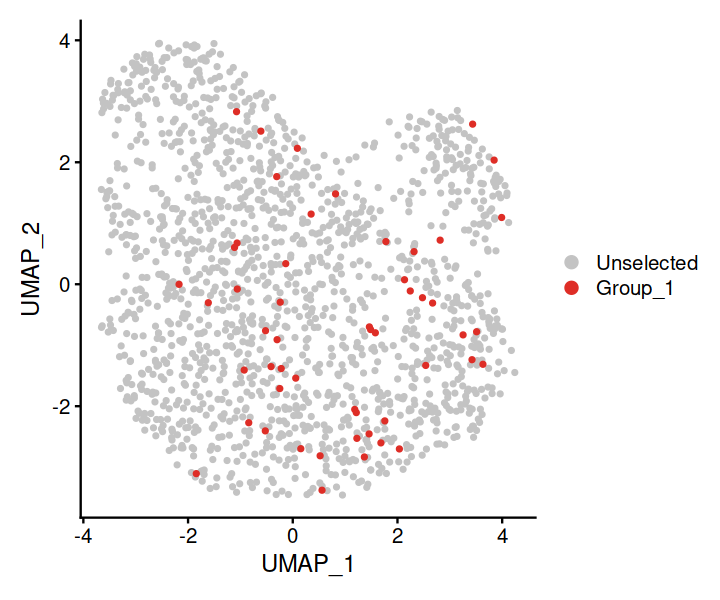

In [7]:
DimPlot(cd4_unc, cells.highlight = colnames(cd4_unc)[grep(cd4_unc$cdr3_A1, pattern = "CVVSDRGSTLGRLYF")])

In [8]:
cd4_unc@meta.data  <- cd4_unc@meta.data  %>% 
mutate(annotations_l3 = recode_factor(seurat_clusters, 
                                     "0" = "iNKT KLRB1hi",
                                     "1" = "iNKT KLRB1lo",
                                     "2" = "Unconventional ZBTB16-",
                                     "3" = "iNKT ISAGhi"))

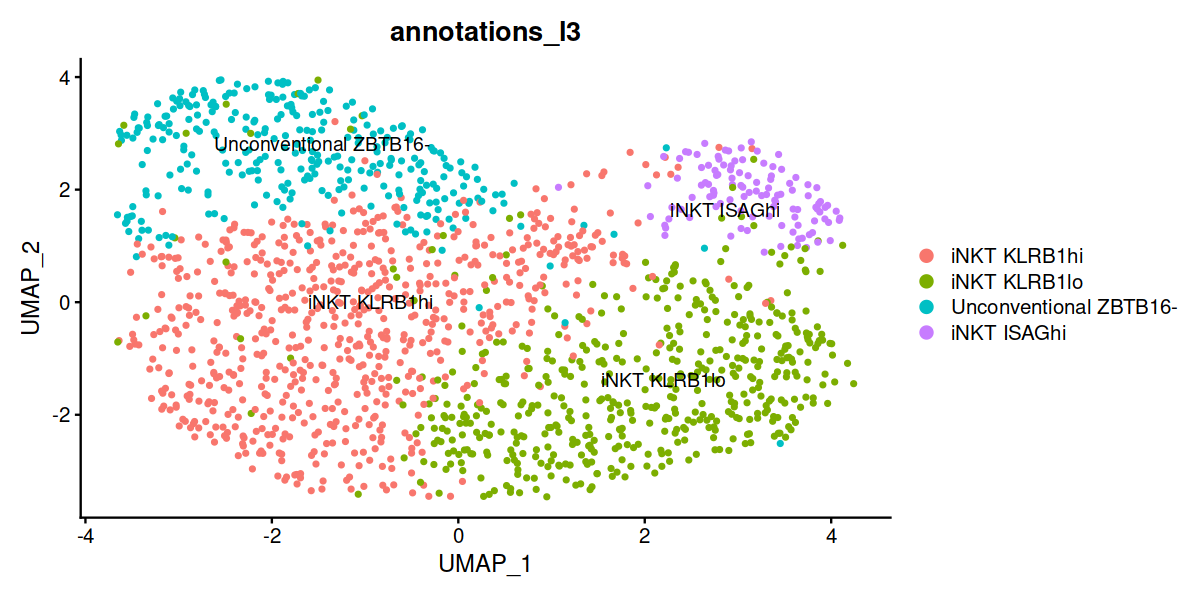

In [9]:
options(repr.plot.width = 10, repr.plot.height = 5)

DimPlot(cd4_unc, label = T, group.by = "annotations_l3", repel = T)

In [453]:
cd4_unc@misc$cols_annotations_l3  <- c(
     "#ed6378ff", # Th1
     "#B07AA1", #Th2
     "#f497abff" , #Mem CCR7
    "#ea2349ff",  #Mem CCR10
    "#D4A6C8", # Th17
    "indianred3", # Exhausted
     "#ffc8c1ff",  #Unconventional
   "#8a1729ff",  # Temra
    "#D90017") # Proliferating)

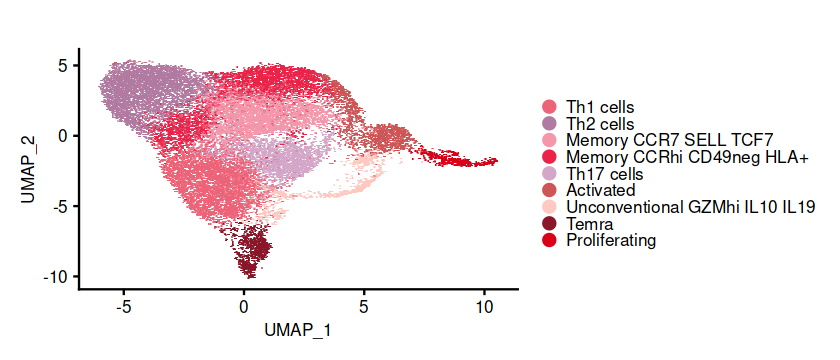

In [454]:
options(repr.plot.width = 7, repr.plot.height = 3)

dimplot1  <- DimPlot(cd4_unc, label = F, raster = T, group.by = "annotations_l3",
                    cols = cd4_unc@misc$cols_annotations_l3, pt.size = 2) + 
ggtheme() + 
ggtitle("")
dimplot1

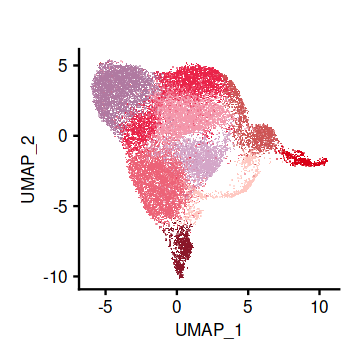

In [437]:
options(repr.plot.width = 3, repr.plot.height = 3)

dimplot1 + NoLegend()
ggsave("dimplot_cd4_unc.png", width = 12, height = 12, units = "cm")
ggsave("dimplot_cd4_unc.svg", width = 12, height = 12, units = "cm")

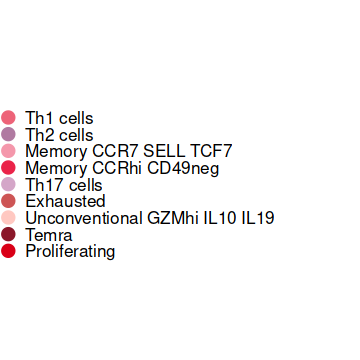

In [438]:
my_legend <- get_legend(dimplot1)
my_legend <- as_ggplot(my_legend) + ggtheme()
my_legend
ggsave("legend_dimplot_cd4_unc.png", width = 12, height = 12, units = "cm")
ggsave("legend_dimplot_cd4_unc.svg", width = 12, height = 12, units = "cm")

In [458]:
levels = c("Th1 cells","Th2 cells","Memory CCR7 SELL TCF7", "Memory CCRhi CD49neg HLA+",
                                     "Th17 cells",
                                     "Exhausted",
                                     "Unconventional GZMhi IL10 IL19",
                                     "Temra",
                                    "Proliferating")

In [459]:
options(repr.plot.width = 15, repr.plot.height = 5)

seurat_meta_data <- cd4_unc@meta.data

# Create grouped dataframe, calculate the frequencies of clusters
df4 <- seurat_meta_data %>% 
  group_by(Sample_ID, annotations_l3) %>% 
  summarise(n = n()) %>% 
  unique() %>% 
  mutate(freq = n / sum(n))  %>% 
dplyr::select(-n)  %>% 
ungroup   %>% 
pivot_wider(names_from = "annotations_l3", values_from = "freq", values_fill = 0)   %>% 
pivot_longer(!Sample_ID, values_to = "freq", names_to = "annotations_l3")
# Control - all sums should be one
# df4 %>% group_by(Sample_ID) %>% summarise(sum = sum(freq))

# As we've lost non-grouping variables, let's join them back
md_to_join <- seurat_meta_data %>% 
  dplyr::select(Sample_ID, Condition, Disease, Sex, Age, Age_group, Patient_ID, Time, Experiment_ID) %>% 
  unique()

df4  <- left_join(df4, md_to_join)

# The final plot

p0  <- df4 %>% 
  ggplot(aes(x = Condition, y = freq)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.7, width = 0.9, aes(fill = Condition)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, shape = 21, stackdir='center', aes(fill = Condition), color = "black") + 
  facet_wrap(~annotations_l3, scales = "free", ncol = 6) +
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
 ylim(0,NA) +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text.x = element_text(angle = 90))

`summarise()` has grouped output by 'Sample_ID'. You can override using the
`.groups` argument.
Joining with `by = join_by(Sample_ID)`
Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


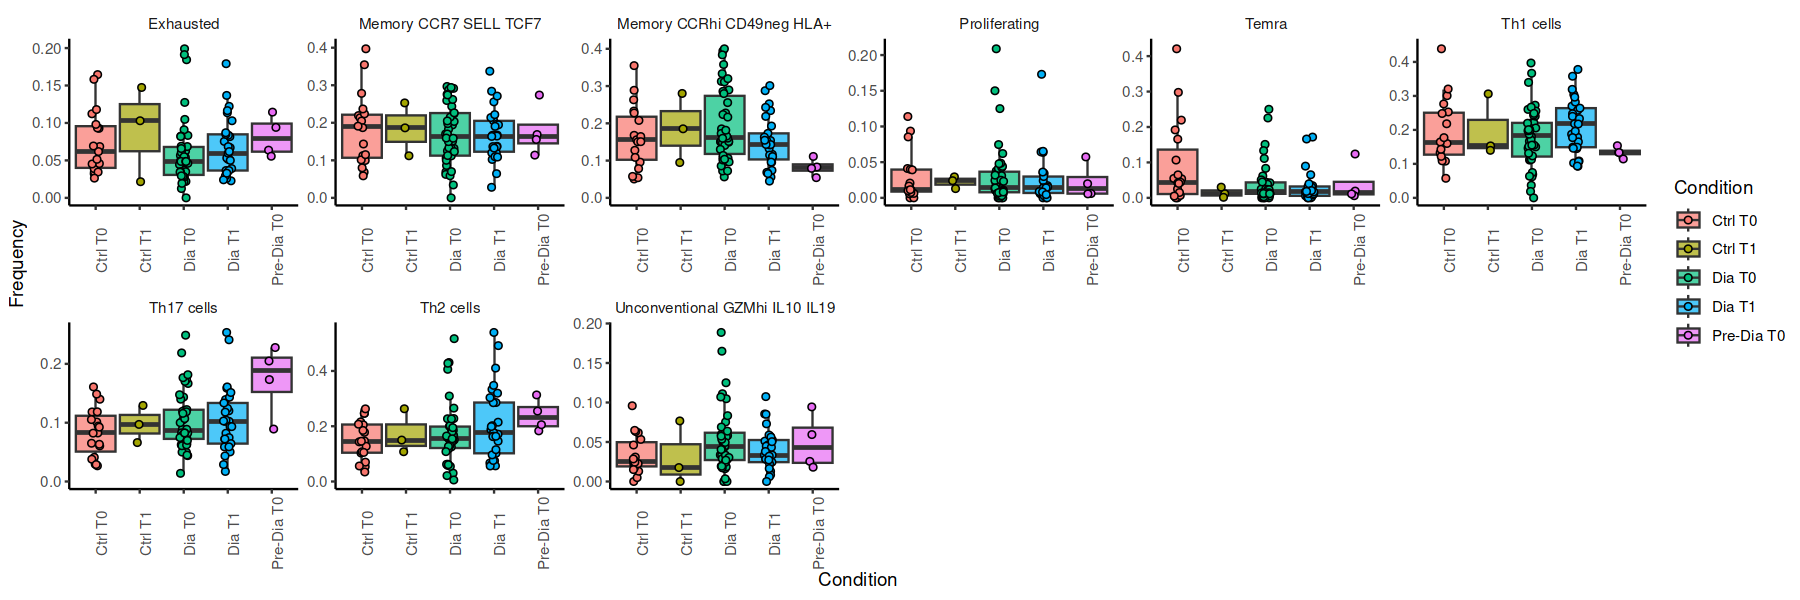

In [460]:
p0

Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


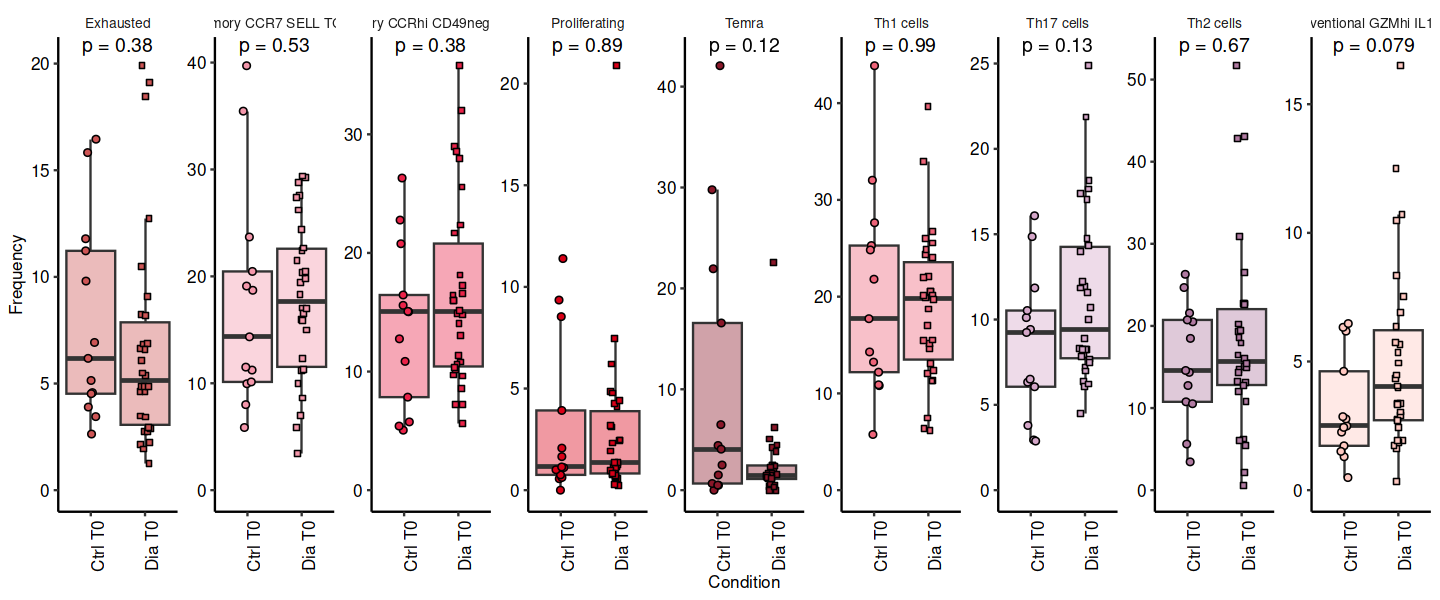

In [461]:
options(repr.plot.width = 12, repr.plot.height = 5)

p1  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition, y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.4, width = 0.9, aes(fill = factor(annotations_l3, levels = levels))) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, stackdir='center', aes(fill = factor(annotations_l3, levels = levels), shape = Condition), color = "black") + 
  facet_wrap(~annotations_l3, scales = "free", ncol = 13) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = cd4_unc@misc$cols_annotations_l3) +
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -1, label = "p.format")+
ggtheme() +
 ylim(0,NA) +
theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()

p1

In [462]:
ggsave("figures/boxplot_cd4_unc_1.png", width = 16, height = 8, units = "cm")
ggsave("figures/boxplot_cd4_unc_1.svg", width = 16, height = 8, units = "cm")


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


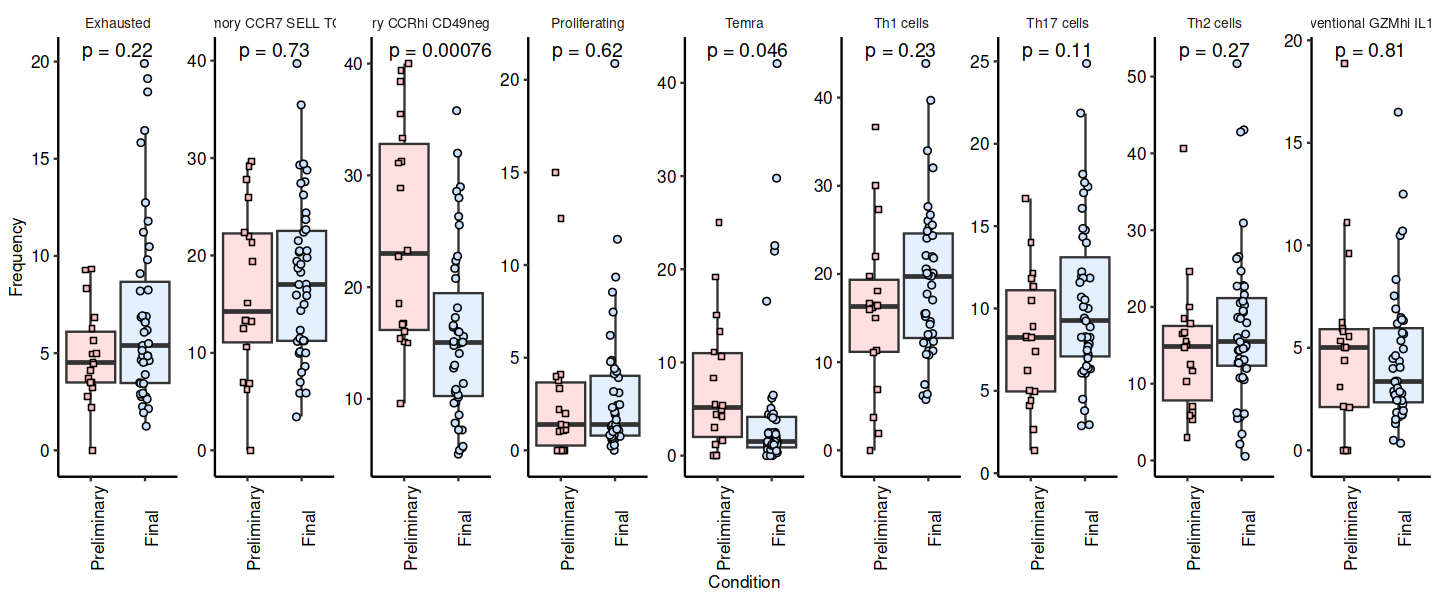

In [463]:
p2  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0"))  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
  ggplot(aes(x = factor(Exp, levels = c("Preliminary", "Final")), y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = Exp)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, stackdir='center', aes(fill = Exp, shape = Exp), color = "black") + 
  facet_wrap(~annotations_l3, scales = "free", ncol = 9) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = c("lightsteelblue1","rosybrown1"))+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -0.5, label = "p.format")+
ggtheme() +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()
p2

In [464]:
ggsave("figures/boxplot_cd4_unc_2.png", width = 16, height = 8, units = "cm")
ggsave("figures/boxplot_cd4_unc_2.svg", width = 16, height = 8, units = "cm")


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


In [465]:
levels2  <- c("AA+", paste("Other", levels))

Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.2, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


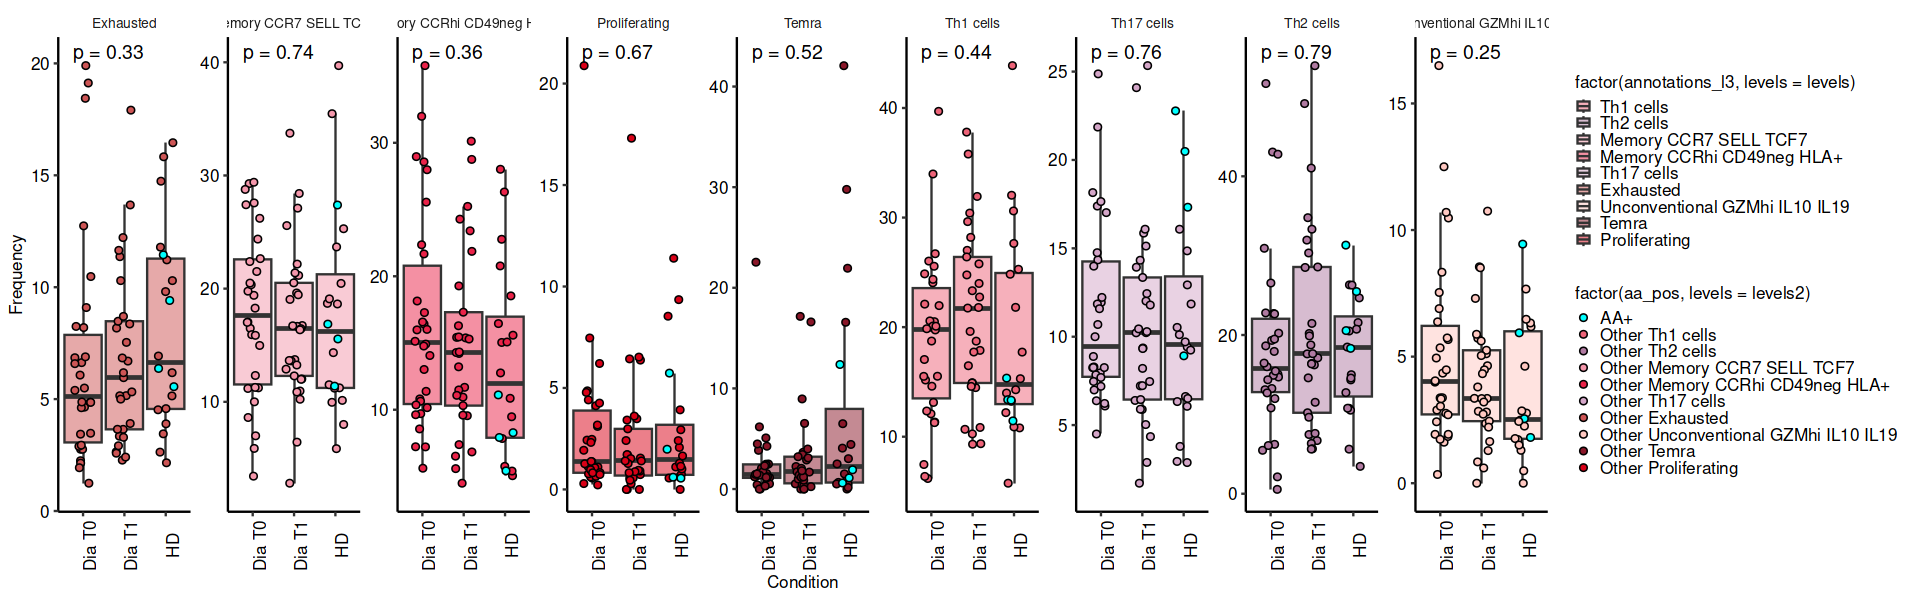

In [467]:
options(repr.plot.width = 16, repr.plot.height = 5)

p3  <- df4  %>% 
mutate(Condition2 = if_else(Disease %in% c("Ctrl", "Pre-Dia"), "HD", Condition))  %>% 
mutate(aa_pos = if_else(Disease %in% c("Pre-Dia"), "AA+", paste("Other", annotations_l3)))  %>% 
filter(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition2, y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = factor(annotations_l3, levels = levels))) +
  scale_fill_manual(values = c(cd4_unc@misc$cols_annotations_l3))+
  new_scale_fill() +
  geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
  geom_jitter(binaxis='y', position=position_jitter(width = 0.2, height = 0), 
  size = 1.5, stackdir='center', shape = 21, aes(fill = factor(aa_pos, levels = levels2))) + 
  scale_fill_manual(values = c("#00ffffff",cd4_unc@misc$cols_annotations_l3))+
  
  facet_wrap(~annotations_l3, scales = "free", ncol = 9) +
  ylab("Frequency") +
scale_shape_manual(values = c(21,21,21,21,21,21,21,21,21))+
  xlab("Condition") +
  theme_classic() +
ggtheme() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -0.5, label = "p.format")+
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90))
p3

In [468]:
ggsave("figures/boxplot_cd4_unc_3.png", width = 40, height = 8, units = "cm")
ggsave("figures/boxplot_cd4_unc_3.svg", width = 40, height = 8, units = "cm")

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


### Save freqencies

In [469]:
df4

Sample_ID annotations_l3                 freq        Condition  Disease Sex
1   176       Th1 cells                      0.11340206  Ctrl T0    Ctrl    M  
2   176       Th2 cells                      0.10309278  Ctrl T0    Ctrl    M  
3   176       Memory CCR7 SELL TCF7          0.27835052  Ctrl T0    Ctrl    M  
4   176       Memory CCRhi CD49neg HLA+      0.28865979  Ctrl T0    Ctrl    M  
5   176       Th17 cells                     0.08247423  Ctrl T0    Ctrl    M  
6   176       Exhausted                      0.09278351  Ctrl T0    Ctrl    M  
7   176       Unconventional GZMhi IL10 IL19 0.03092784  Ctrl T0    Ctrl    M  
8   176       Proliferating                  0.01030928  Ctrl T0    Ctrl    M  
9   176       Temra                          0.00000000  Ctrl T0    Ctrl    M  
10  177       Th1 cells                      0.16438356  Ctrl T0    Ctrl    F  
11  177       Th2 cells                      0.17808219  Ctrl T0    Ctrl    F  
12  177       Memory CCR7 SELL TCF7          0.21917808  Ctrl T0    Ctrl    F  
13  177       Memory CCRhi CD49neg HLA+      0.23287671  Ctrl T0    Ctrl    F  
14  177       Th17 cells                     0.04109589  Ctrl T0    Ctrl    F  
15  177       Exhausted                      0.06849315  Ctrl T0    Ctrl    F  
16  177       Unconventional GZMhi IL10 IL19 0.00000000  Ctrl T0    Ctrl    F  
17  177       Proliferating                  0.04109589  Ctrl T0    Ctrl    F  
18  177       Temra                          0.05479452  Ctrl T0    Ctrl    F  
19  178       Th1 cells                      0.03703704  Dia T0     Dia     M  
20  178       Th2 cells                      0.18518519  Dia T0     Dia     M  
21  178       Memory CCR7 SELL TCF7          0.25925926  Dia T0     Dia     M  
22  178       Memory CCRhi CD49neg HLA+      0.18518519  Dia T0     Dia     M  
23  178       Th17 cells                     0.07407407  Dia T0     Dia     M  
24  178       Exhausted                      0.03703704  Dia T0     Dia     M  
25  178       Unconventional GZMhi IL10 IL19 0.11111111  Dia T0     Dia     M  
26  178       Proliferating                  0.00000000  Dia T0     Dia     M  
27  178       Temra                          0.11111111  Dia T0     Dia     M  
28  179       Th1 cells                      0.01886792  Dia T0     Dia     M  
29  179       Th2 cells                      0.15094340  Dia T0     Dia     M  
30  179       Memory CCR7 SELL TCF7          0.13207547  Dia T0     Dia     M  
... ...       ...                            ...         ...        ...     ...
844 457       Unconventional GZMhi IL10 IL19 0.028571429 Ctrl T0    Ctrl    F  
845 457       Proliferating                  0.011428571 Ctrl T0    Ctrl    F  
846 457       Temra                          0.165714286 Ctrl T0    Ctrl    F  
847 458       Th1 cells                      0.114457831 Pre-Dia T0 Pre-Dia F  
848 458       Th2 cells                      0.313253012 Pre-Dia T0 Pre-Dia F  
849 458       Memory CCR7 SELL TCF7          0.168674699 Pre-Dia T0 Pre-Dia F  
850 458       Memory CCRhi CD49neg HLA+      0.054216867 Pre-Dia T0 Pre-Dia F  
851 458       Th17 cells                     0.204819277 Pre-Dia T0 Pre-Dia F  
852 458       Exhausted                      0.114457831 Pre-Dia T0 Pre-Dia F  
853 458       Unconventional GZMhi IL10 IL19 0.018072289 Pre-Dia T0 Pre-Dia F  
854 458       Proliferating                  0.006024096 Pre-Dia T0 Pre-Dia F  
855 458       Temra                          0.006024096 Pre-Dia T0 Pre-Dia F  
856 459       Th1 cells                      0.153465347 Pre-Dia T0 Pre-Dia M  
857 459       Th2 cells                      0.183168317 Pre-Dia T0 Pre-Dia M  
858 459       Memory CCR7 SELL TCF7          0.113861386 Pre-Dia T0 Pre-Dia M  
859 459       Memory CCRhi CD49neg HLA+      0.079207921 Pre-Dia T0 Pre-Dia M  
860 459       Th17 cells                     0.173267327 Pre-Dia T0 Pre-Dia M  
861 459       Exhausted                      0.094059406 Pre-Dia T0 Pre-Dia M  
862 

In [470]:
freq  <- df4  %>% dplyr::select(1:3)
write.csv(freq, "freq_cd4_unc.csv", row.names = FALSE)

# Tree

In [471]:
cd4_md  <- cd4_full_filt@meta.data  %>% dplyr::select(barcode, annotations_l1)

In [472]:
cd4_md  <- left_join(cd4_md, (cd4_subcluster@meta.data  %>% dplyr::select(barcode, annotations_l2)))

Joining with `by = join_by(barcode)`


In [474]:
cd4_md  <- left_join(cd4_md, (treg_subcluster@meta.data  %>% dplyr::select(barcode, annotations_l3_treg = annotations_l3)))

Joining with `by = join_by(barcode)`


In [475]:
cd4_md  <- left_join(cd4_md, (teff_subcluster@meta.data  %>% dplyr::select(barcode, annotations_l3_teff = annotations_l3)))

Joining with `by = join_by(barcode)`


In [476]:
cd4_md  <- cd4_md  %>% mutate(annotations_l3 = if_else(!is.na(annotations_l3_treg), annotations_l3_treg, annotations_l3_teff))

In [477]:
cd4_md  <- cd4_md  %>% dplyr::select(barcode, annotations_l1, annotations_l2, annotations_l3)

In [479]:
cd4_md$annotations  <- "CD4"

In [480]:
cd4_md  <- cd4_md  %>% mutate(annotations_l3 = case_when(
annotations_l1 == "CD4 T cells" ~ paste("CD4", annotations_l2),
annotations_l1 == "Unconventional T cells" ~ annotations_l2
))

In [481]:
data  <- cd4_md  %>% dplyr::select(-barcode)  %>% 
    group_by(annotations, annotations_l1, annotations_l2)  %>% 
tally()

In [482]:
data

annotations annotations_l1         annotations_l2 n    
1  CD4         CD4 T cells            Tfh            21741
2  CD4         CD4 T cells            Naive          15765
3  CD4         CD4 T cells            Th17            7944
4  CD4         CD4 T cells            Tcm2            7324
5  CD4         CD4 T cells            Th1             6726
6  CD4         CD4 T cells            Tcm1            6601
7  CD4         CD4 T cells            Treg naive      5910
8  CD4         CD4 T cells            Th2             3872
9  CD4         CD4 T cells            Treg memory     3861
10 CD4         CD4 T cells            ISAGhi          2841
11 CD4         CD4 T cells            Proliferating   1271
12 CD4         CD4 T cells            Exhausted       1158
13 CD4         CD4 T cells            Temra            864
14 CD4         Unconventional T cells NA              1681

In [483]:
data  %>% write.csv("cd4_tree_sankey.csv", row.names = F)

Sankey plot using https://app.rawgraphs.io/